# Comparison of performance, frequency and temperature evolutions on Dahu@G5K

The goal of these experiments is to observe the evolution of the temperature, frequencies and performance on Dahu.

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning

def read_simple_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    return result

def cores_to_str(cores):
    if set(cores) == set(range(32)):
        return 'all cores'
    elif set(cores) == set(range(0, 32, 2)):
        return 'even cores'
    elif set(cores) == set(range(1, 32, 2)):
        return 'odd cores'
    else:
        return ' '.join([str(n) for n in sorted(cores)])

def cores_from_expid(exp_id):
    cores = exp.iloc[exp_id].cores
    cores = [int(n) for n in cores.split()]
    return cores

def read_csv(archive_name, file_name):
    result = read_simple_csv(archive_name, file_name)
    info = get_yaml(archive_name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    idx = hostname[0].index('.')
    hostname = hostname[0][:idx]
    idx = hostname.index('-')
    node = int(hostname[idx+1:])
    cluster = hostname[:idx]
    result['hostname'] = hostname
    result['node'] = node
    result['cluster'] = cluster
    result['jobid'] = info['jobid']
    result['filename'] = archive_name
    result['start'] = pandas.to_datetime(result['start'])
    result['stop'] = pandas.to_datetime(result['stop'])
    return result

def read_result(name, exp_id=0):
    freq = read_csv(name, 'stress_freq_%d.csv' % exp_id)
    temp = read_csv(name, 'stress_temp_%d.csv' % exp_id)
    perf = read_csv(name, 'stress_perf_%d.csv' % exp_id)
    min_time = min(freq.start.min(), temp.start.min(), perf.start.min())
    for df in [freq, temp, perf]:
        for name in ['start', 'stop']:
            df[name] -= min_time
            df['exp_id'] = exp_id
            df['exp_type'] = cores_to_str(cores_from_expid(exp_id))
    return freq, temp, perf

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'data/9/'
exp_files = [directory + filename for filename in os.listdir(directory)]

exp = pandas.concat([read_simple_csv(filename, 'exp_stress.csv') for filename in exp_files]).drop_duplicates()

freq = []
temp = []
perf = []
exp_id = 0
while True:
    try:
        results = [read_result(filename, exp_id=exp_id) for filename in exp_files]
    except KeyError:
        break
    freq.append(pandas.concat([t[0] for t in results]))
    temp.append(pandas.concat([t[1] for t in results]))
    perf.append(pandas.concat([t[2] for t in results]))
    exp_id += 1

freq = pandas.concat(freq)
temp = pandas.concat(temp)
perf = pandas.concat(perf)

freq['frequency'] *= 1e-9

exp

,mode,size,nb_calls,nb_runs,nb_sleeps,sleep_time,cores,index
0,loop,2048,4000,1,0,1.0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0


Truncating the data to 30 minutes. At the end of the experiment, some cores terminate their work a bit before others. As a result, we can see in the plots that the performance and the frequency increase. This is understandable, but can be misleading in a presentation (and this is not the point). So let's just crop the visualizations.

In [2]:
freq = freq[freq['start'] <= pandas.to_timedelta(30, unit='m')]
temp = temp[temp['start'] <= pandas.to_timedelta(30, unit='m')]
perf = perf[perf['start'] <= pandas.to_timedelta(30, unit='m')]

In [3]:
freq.head()

,hostname,start,stop,core_id,frequency,index,node,cluster,jobid,filename,exp_id,exp_type
0,dahu-10,00:00:00.000252,00:00:00.001965,0,2.799957,0,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
1,dahu-10,00:00:00.000252,00:00:00.001965,1,2.799957,1,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
2,dahu-10,00:00:00.000252,00:00:00.001965,2,2.799957,2,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
3,dahu-10,00:00:00.000252,00:00:00.001965,3,2.799957,3,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
4,dahu-10,00:00:00.000252,00:00:00.001965,4,2.638458,4,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores


In [4]:
temp.head()

,hostname,start,stop,sensor_id,temperature,index,node,cluster,jobid,filename,exp_id,exp_type
0,dahu-10,00:00:00,00:00:00.000201,0,47.0,0,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
1,dahu-10,00:00:00,00:00:00.000201,1,41.0,1,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
2,dahu-10,00:00:01.102223,00:00:01.102610,0,54.0,2,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
3,dahu-10,00:00:01.102223,00:00:01.102610,1,45.0,3,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
4,dahu-10,00:00:02.105783,00:00:02.106073,0,55.0,4,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores


In [5]:
perf.head()

,start,stop,duration,nb_cycles,core_id,gflops,index,hostname,node,cluster,jobid,filename,exp_id,exp_type
0,00:00:00.058400,00:00:00.623440,565039780,1183798124,0,30.40471,0,dahu-10,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
1,00:00:00.623513,00:00:01.184142,560629194,1174544650,0,30.64391,1,dahu-10,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
2,00:00:01.184177,00:00:01.744777,560599325,1174477334,0,30.64554,2,dahu-10,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
3,00:00:01.744814,00:00:02.306952,562137876,1177701990,0,30.56166,3,dahu-10,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores
4,00:00:02.306976,00:00:02.873787,566810307,1187490430,0,30.30973,4,dahu-10,10,dahu,1885284,data/9/grenoble_2019-09-26_1885284.zip,0,all cores


## Removing the "wrong" cores in the frequency dataframe

Half of the cores have a constant frequency in the dataframe. The reason is probably because we have 64 distinct cores here: it includes the hyperthreads...
So, let's remove them.

In [6]:
tmp = freq.groupby(['node', 'core_id'])[['frequency']].agg(['min', 'median', 'max'])
tmp.columns = tmp.columns.droplevel(0)
tmp = tmp.reset_index()
old_len = len(tmp)
tmp = tmp[tmp['min'] == tmp['max']]
new_len = len(tmp)
print('Distinct cores: %d → %d' % (old_len, new_len))
assert old_len == new_len*2
cores = set(tmp.core_id)
assert len(cores) * 2 == len(freq.core_id.unique())  # check that the same cores are problematic on all nodes, to speed-up the computation
old_len = len(freq)
freq = freq[~freq.core_id.isin(cores)]
new_len = len(freq)
print('Measures: %d → %d' % (old_len, new_len))
assert old_len == new_len*2

Distinct cores: 1024 → 512
Measures: 1836864 → 918432


## Visualizing the data

### Temperature

In [7]:
def generic_plot(df, y, y_label, draw_line, hline=None):
    min_y = df[y].min()
    max_y = df[y].max()
    max_x = df['start'].max()
    for node in sorted(df.node.unique()):
        tmp = df[df.node == node]
        plot = ggplot(tmp, aes(x='start', y=y, color='factor(cpu)')) + theme_bw()
        hostname = tmp.hostname.unique()[0]
        plot = plot + ylab(y_label) + ggtitle(hostname)
        plot = plot + xlab('Timestamp') + labs(color='CPU')
        if draw_line:
            plot += geom_line()
        else:
            plot += geom_point(shape=0)
        if hline:
            yintercept, unit = hline
            plot = plot + geom_hline(yintercept=yintercept, linetype='dashed', color='grey', size=1)
            plot = plot + annotate('text', label=f'{yintercept}{unit}', x=pandas.to_timedelta(max_x * .98, 'm'), y=yintercept+(max_y-min_y)/40, color='gray')
        plot = plot + scale_x_timedelta(breaks=pandas.to_timedelta([0, 15, 30], 'm'))
        plot = plot + expand_limits(y=[min_y, max_y])
        print(plot)
        ggsave(plot=plot, filename=f'/tmp/plot_{y}_{hostname}.png', dpi=300)

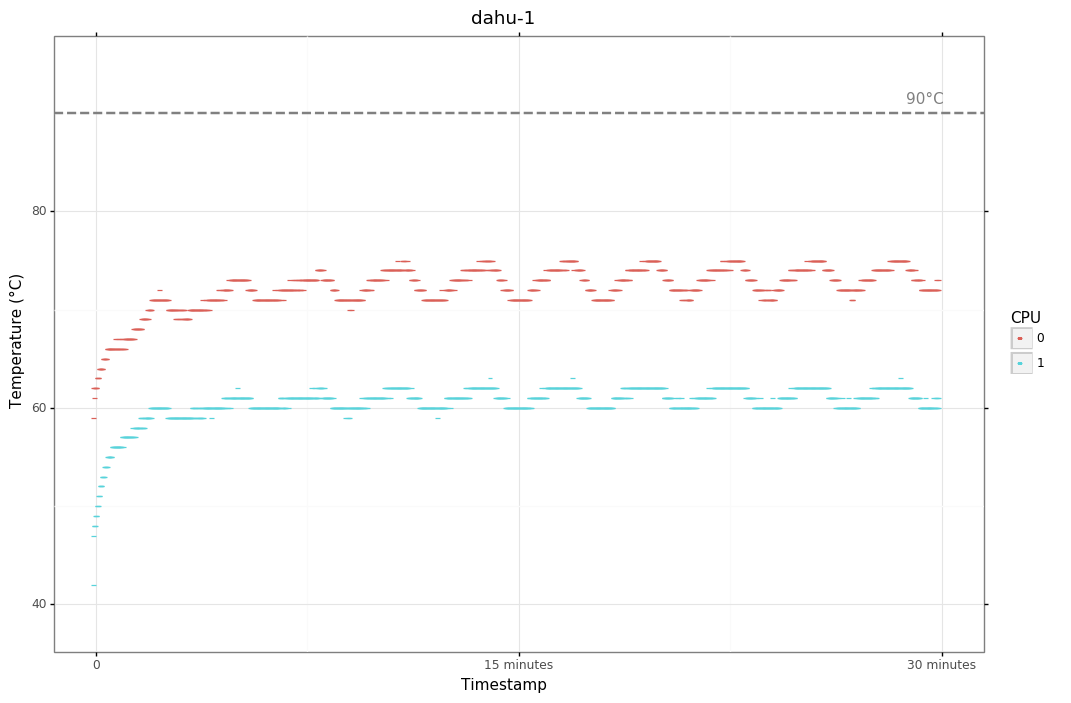

<ggplot: (-9223363243440121919)>


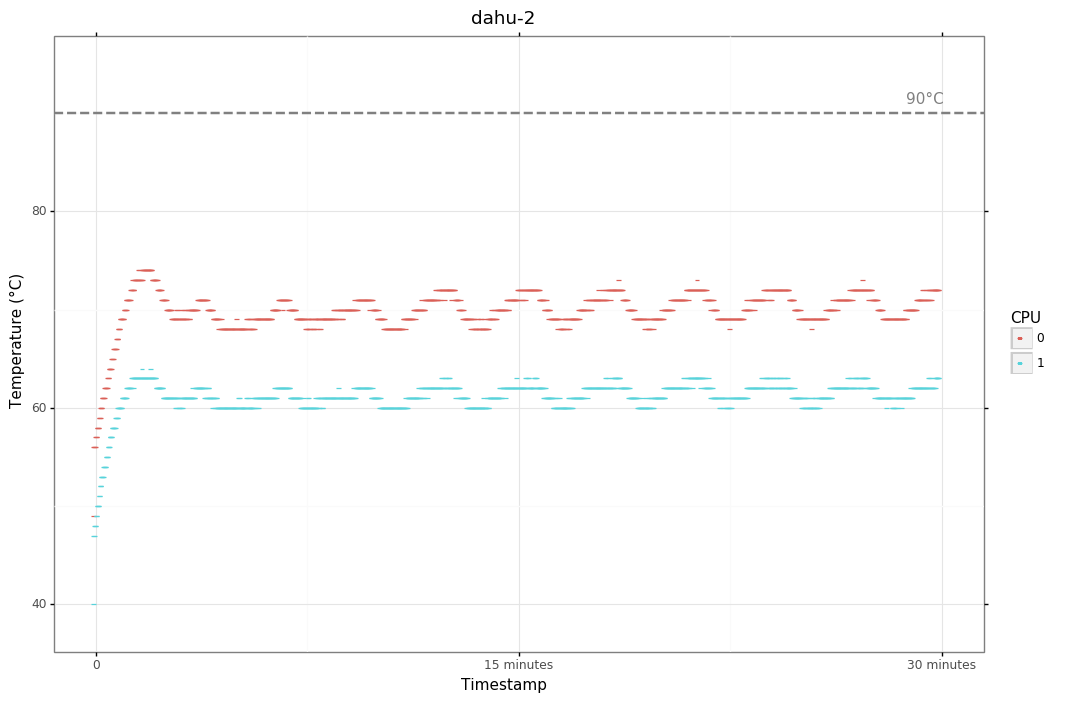

<ggplot: (-9223363243437447743)>


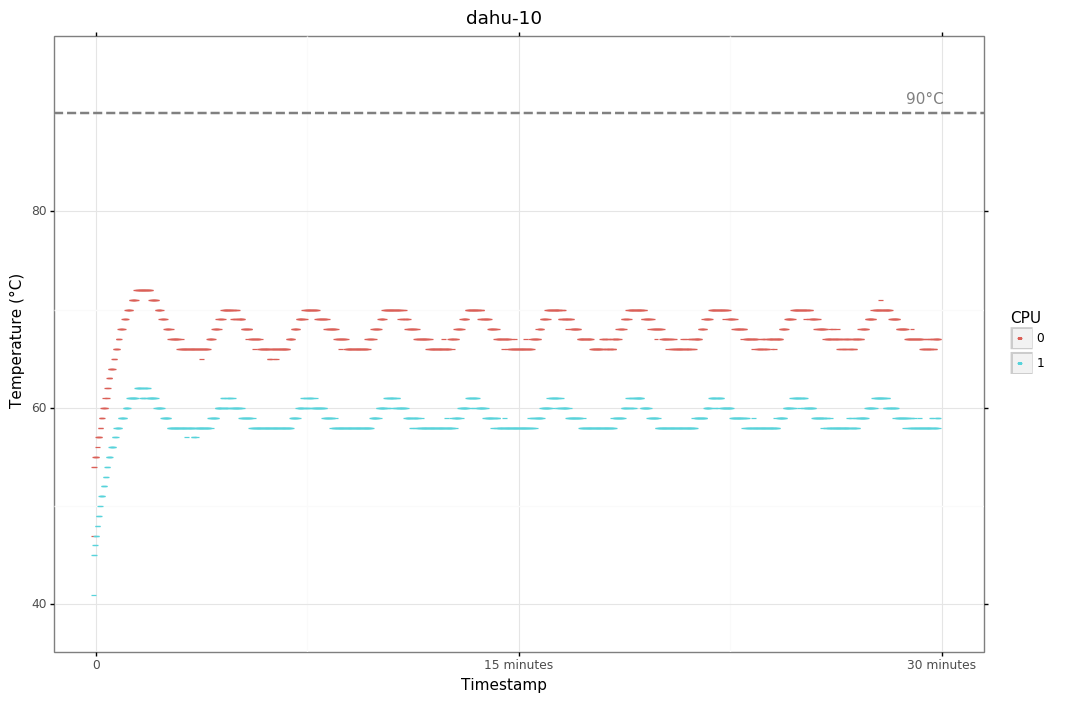

<ggplot: (-9223363243437313995)>


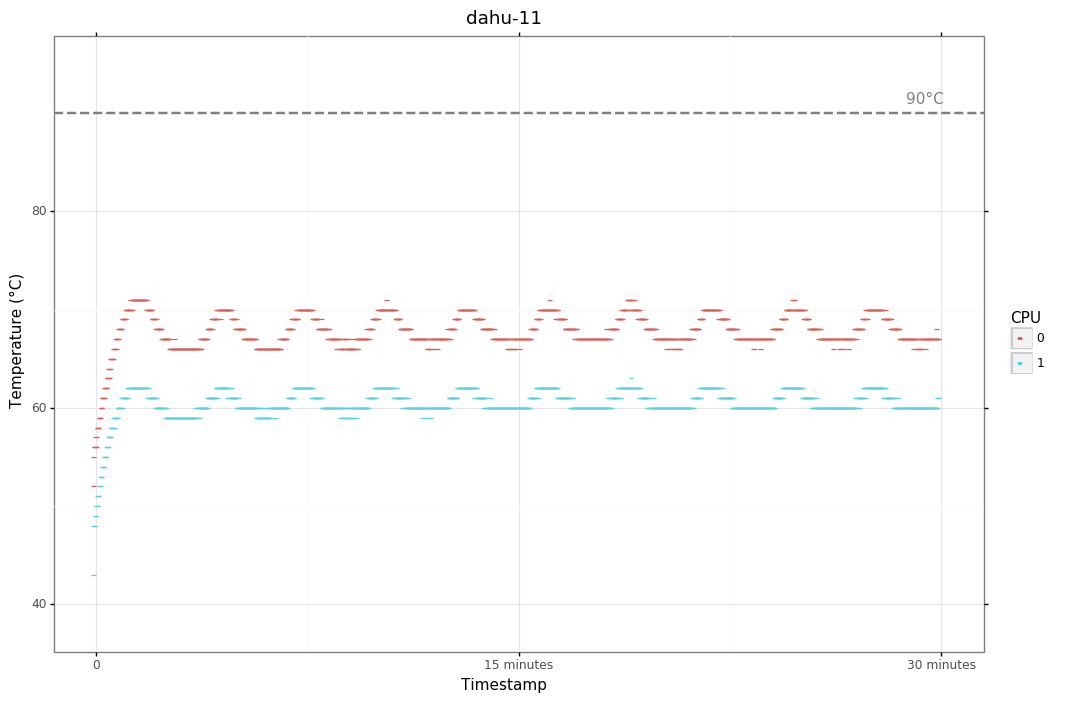

<ggplot: (8793415879772)>


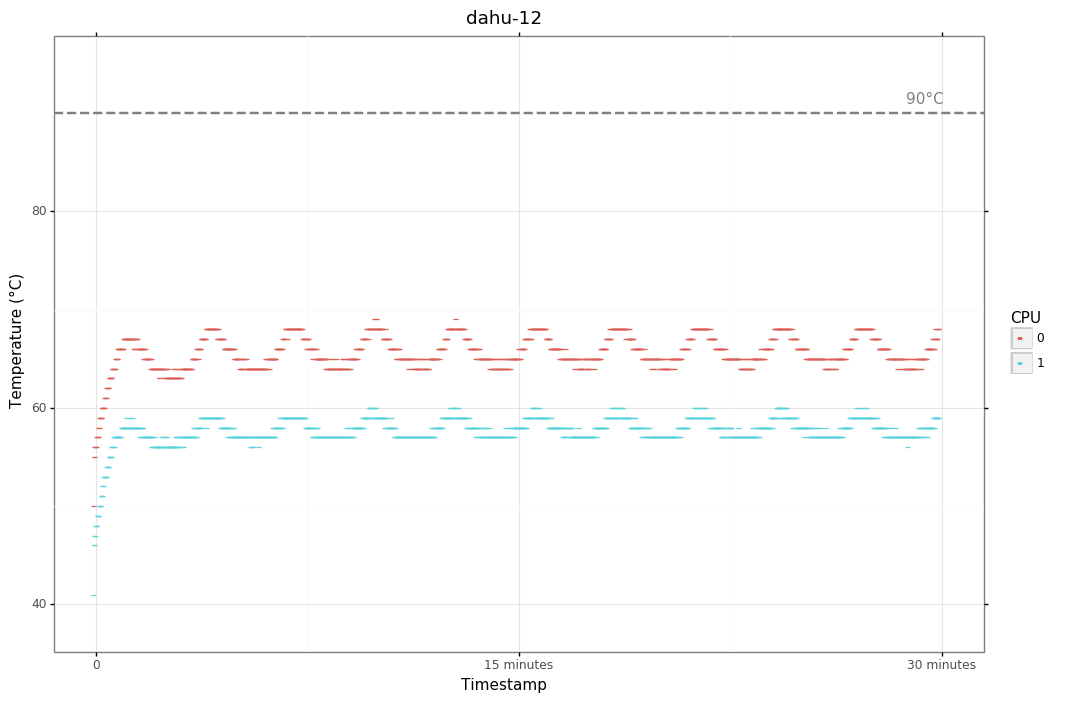

<ggplot: (-9223363243437247751)>


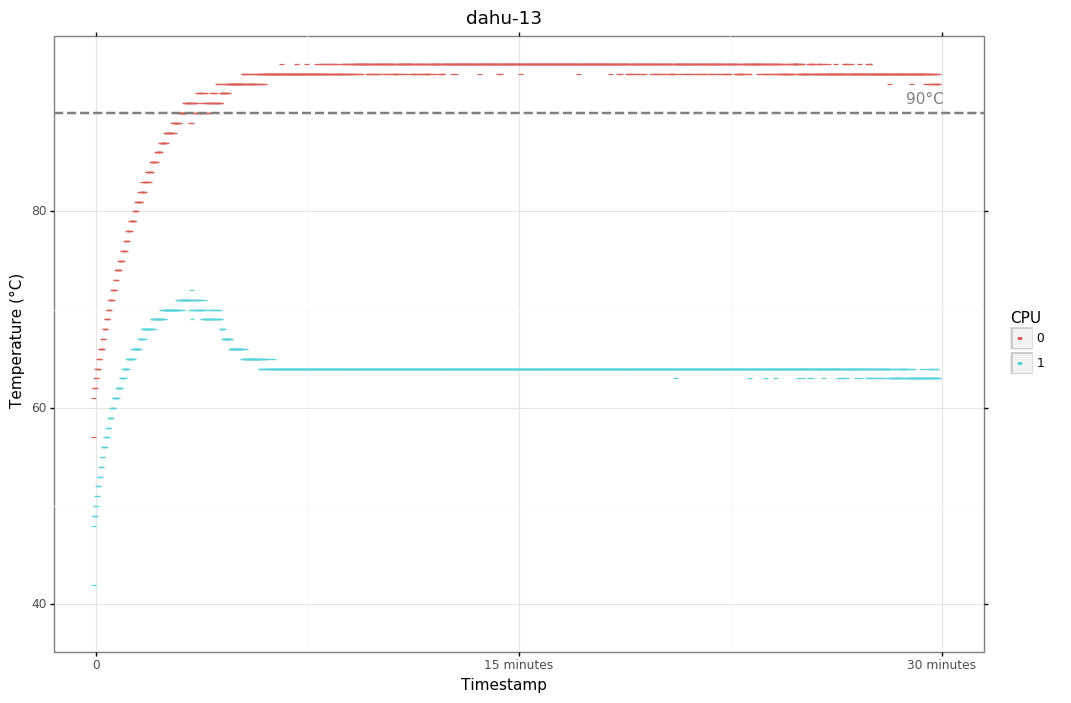

<ggplot: (8793416759097)>


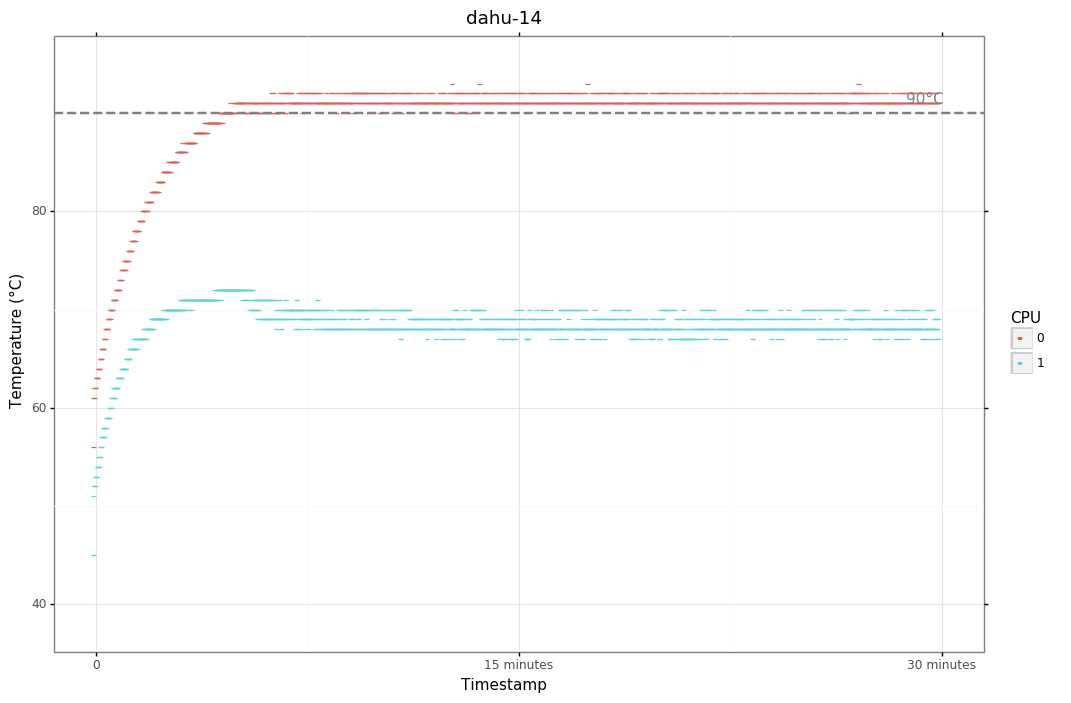

<ggplot: (-9223363243437442230)>


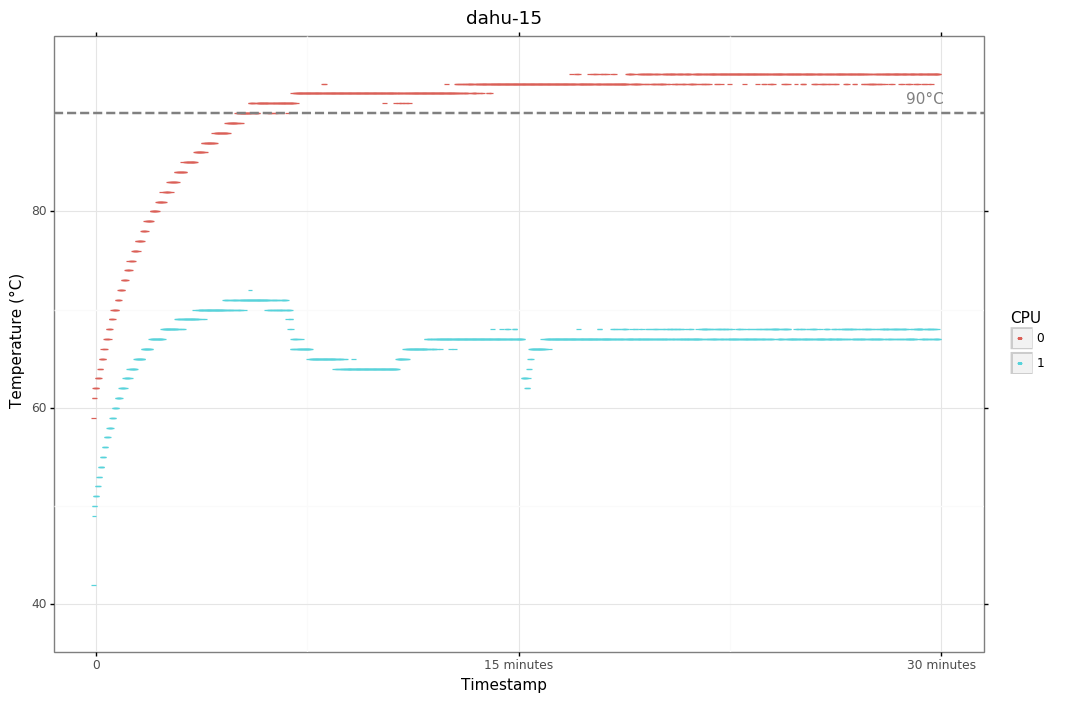

<ggplot: (8793415414413)>


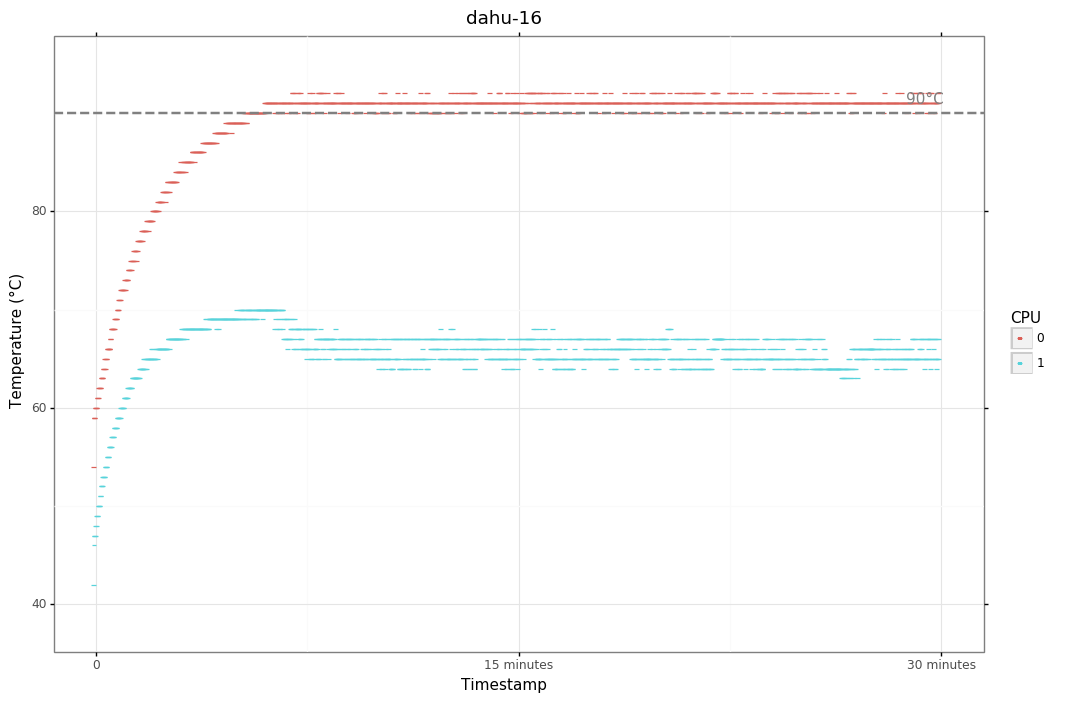

<ggplot: (8793417330773)>


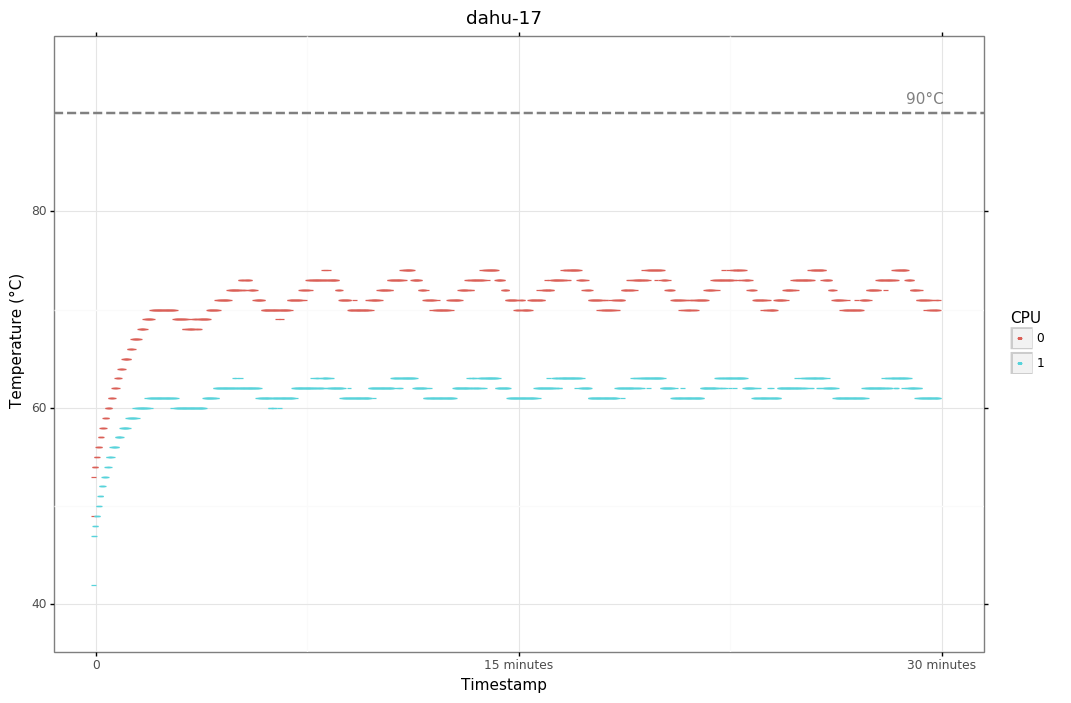

<ggplot: (8793414648226)>


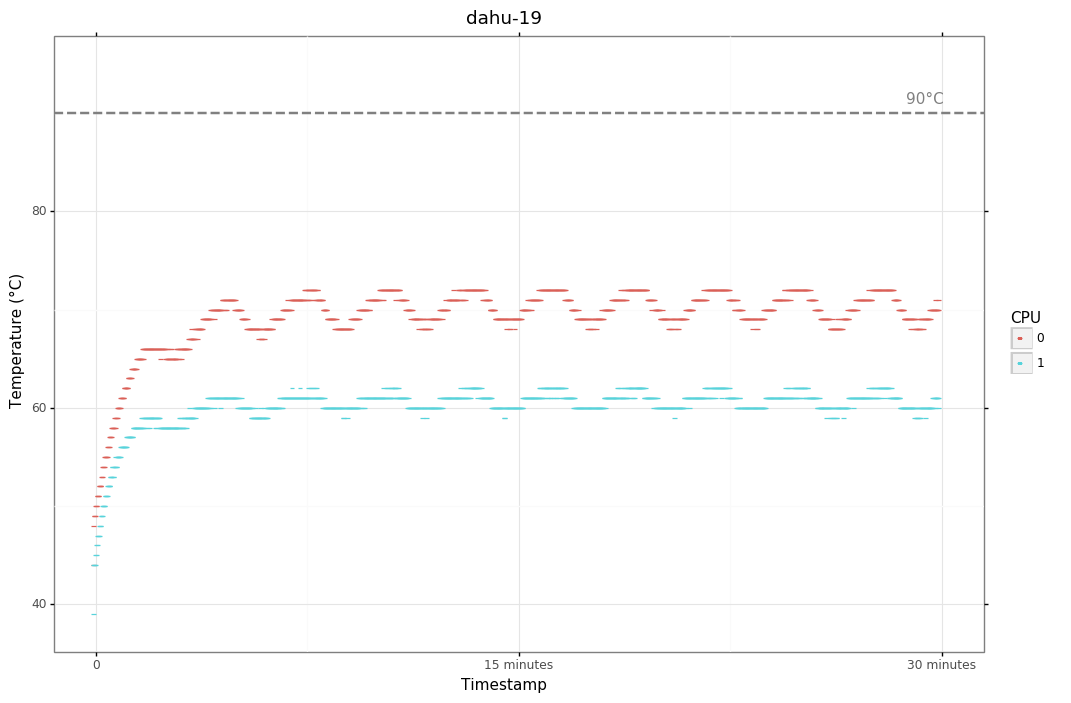

<ggplot: (-9223363243439370503)>


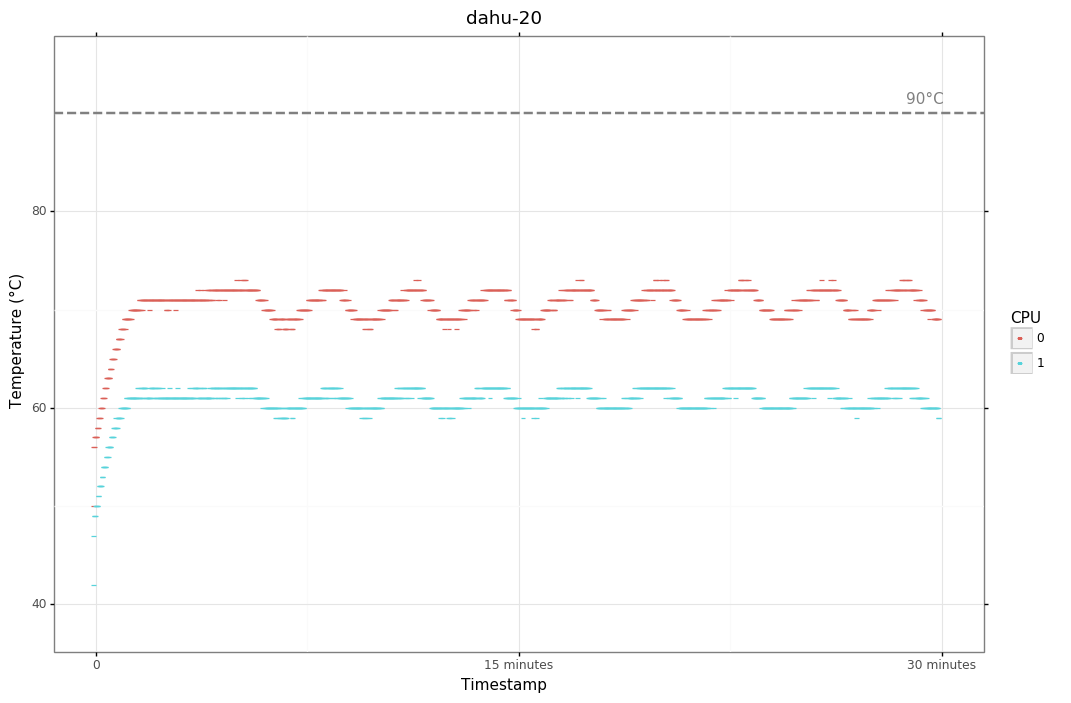

<ggplot: (-9223363243438671665)>


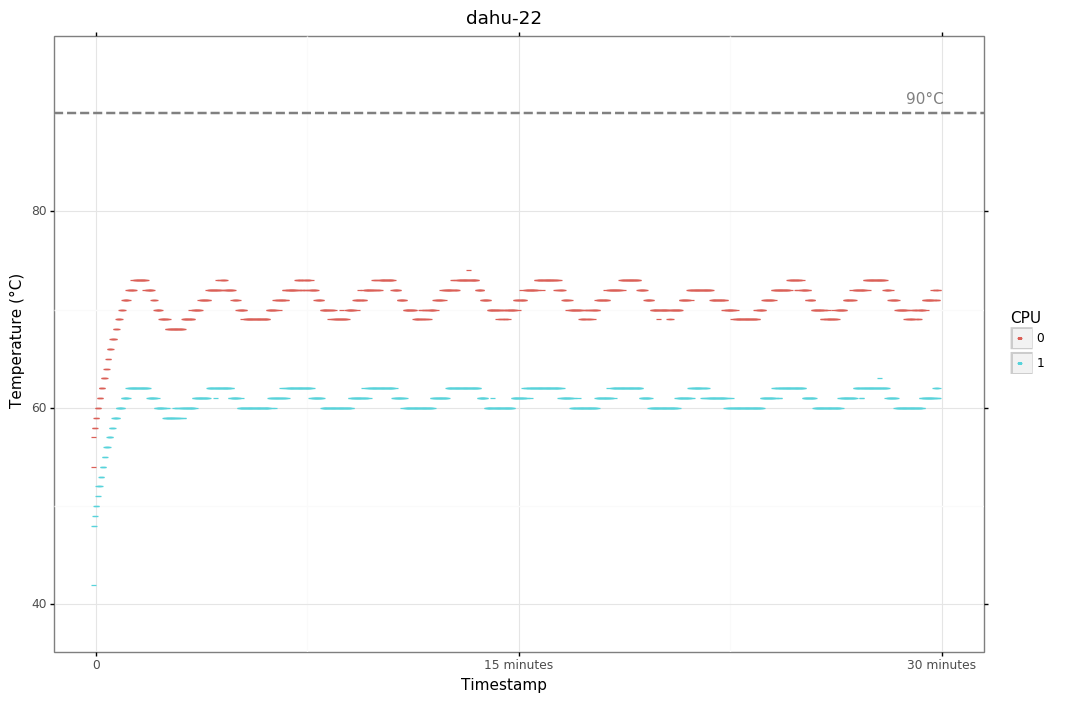

<ggplot: (8793416810518)>


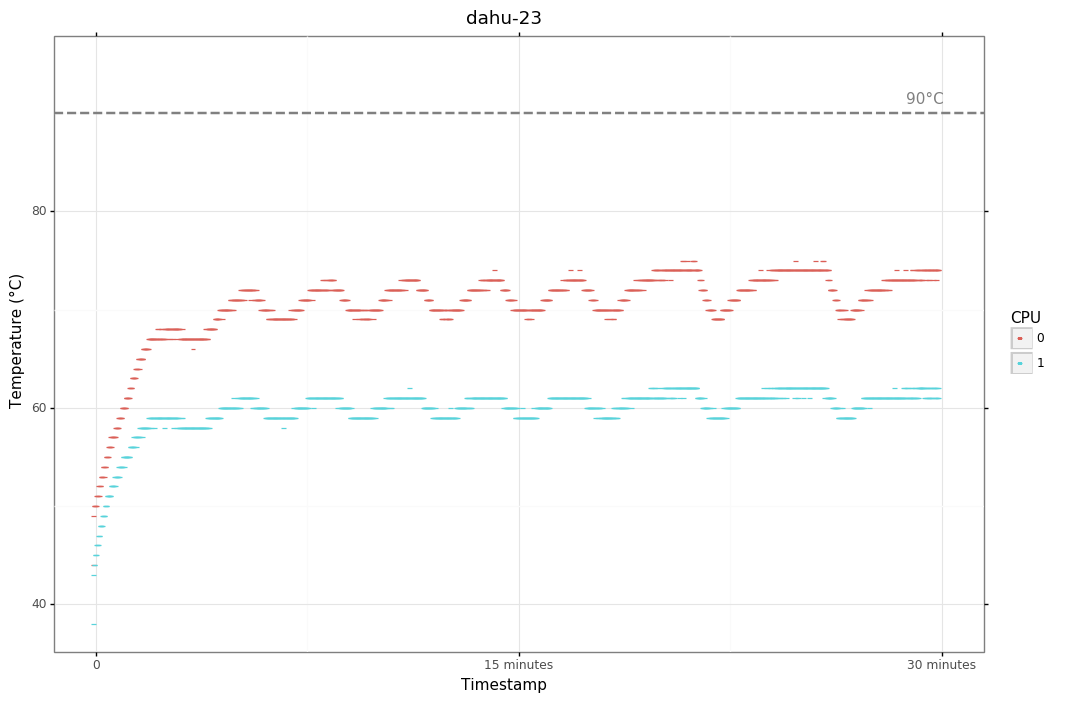

<ggplot: (8793414657053)>


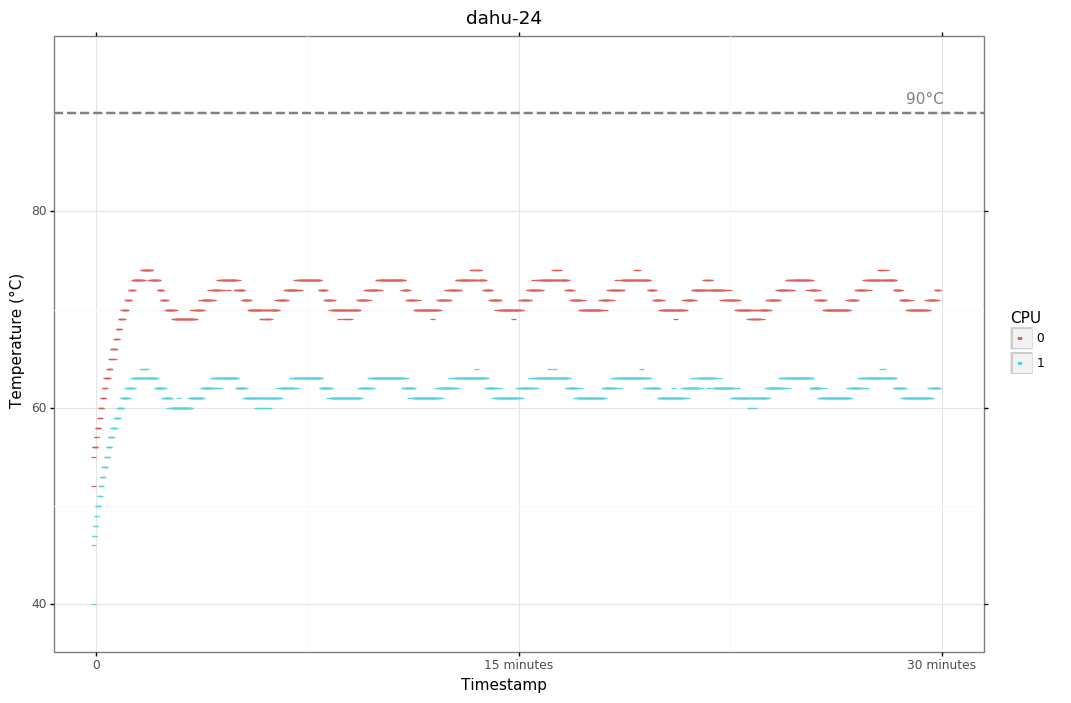

<ggplot: (8793417331446)>


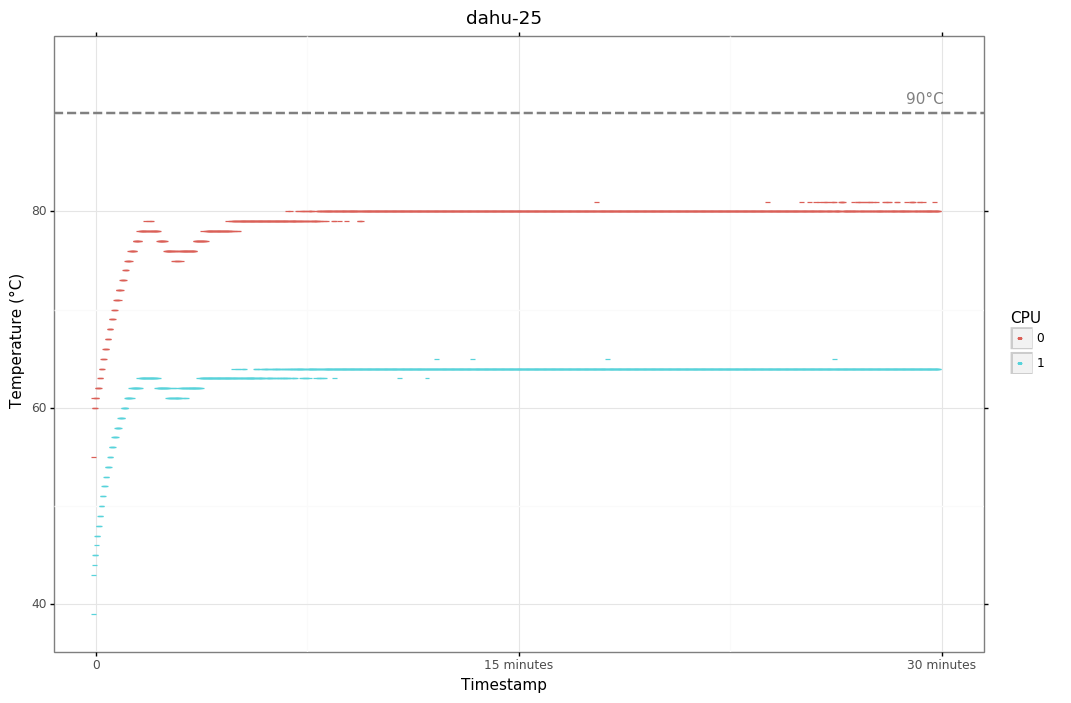

<ggplot: (8793414657039)>


In [8]:
temp['cpu'] = temp['sensor_id']
generic_plot(temp, y='temperature', y_label='Temperature (°C)', draw_line=False, hline=(90, '°C'))

### Frequency

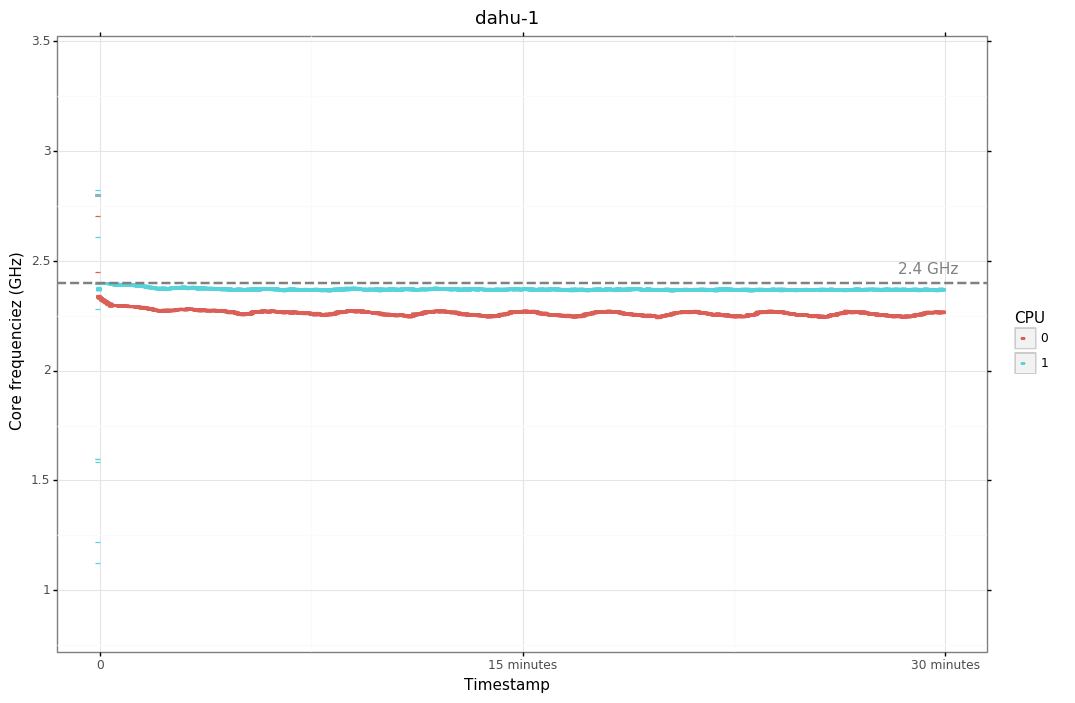

<ggplot: (8793417329300)>


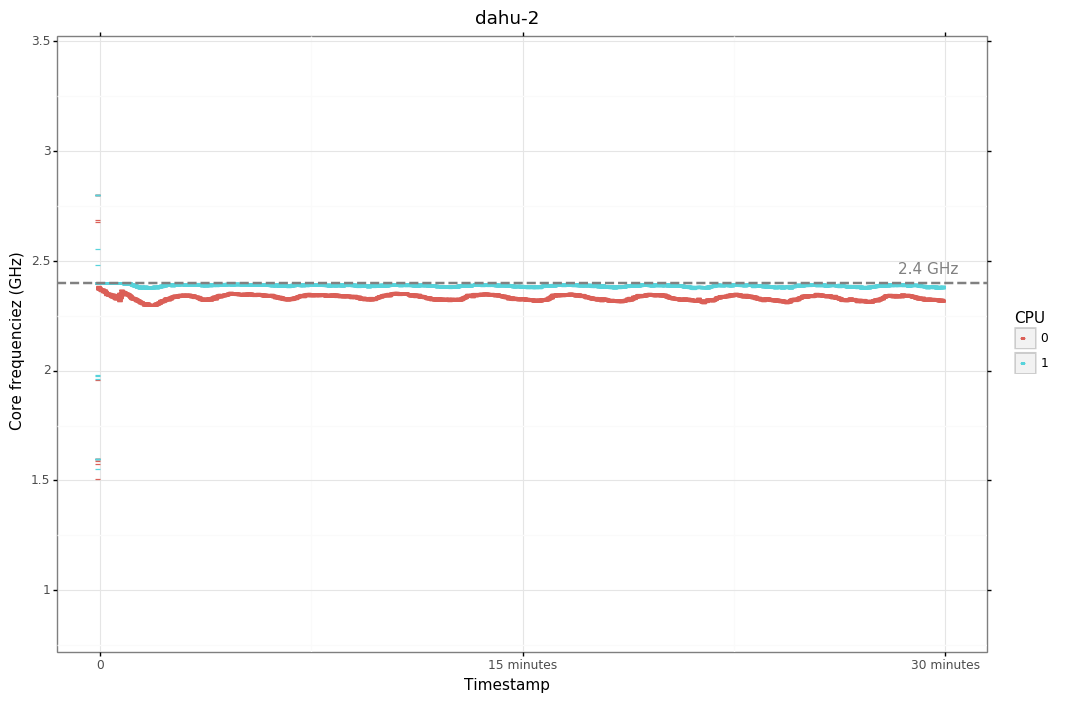

<ggplot: (-9223363243437444583)>


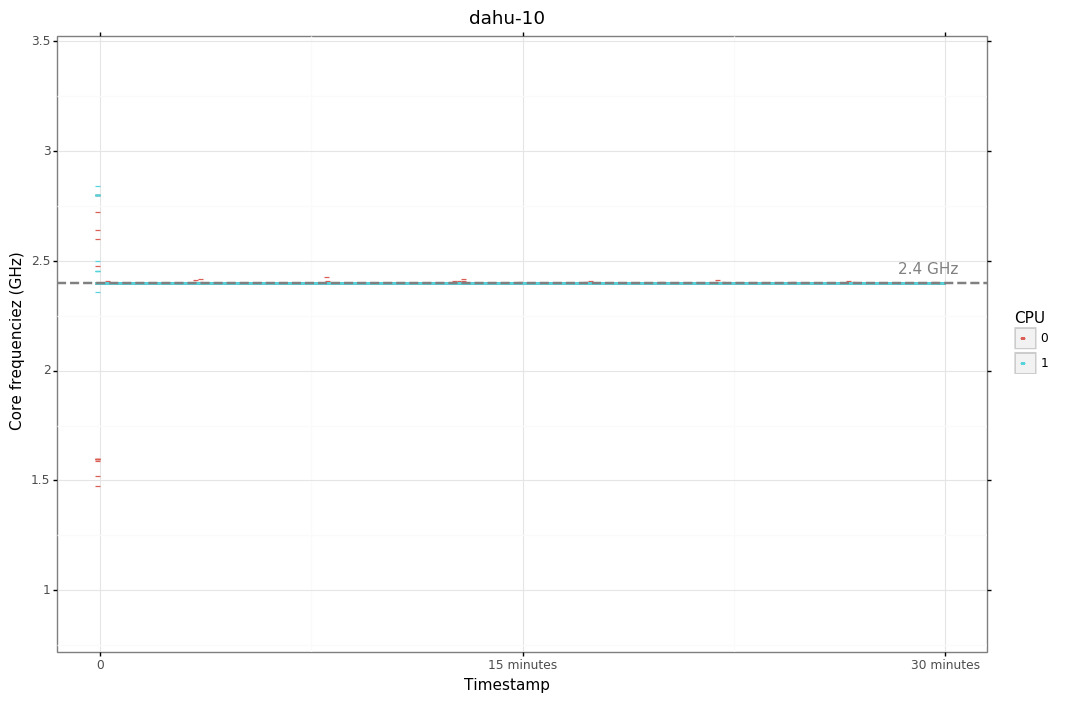

<ggplot: (-9223363243437447813)>


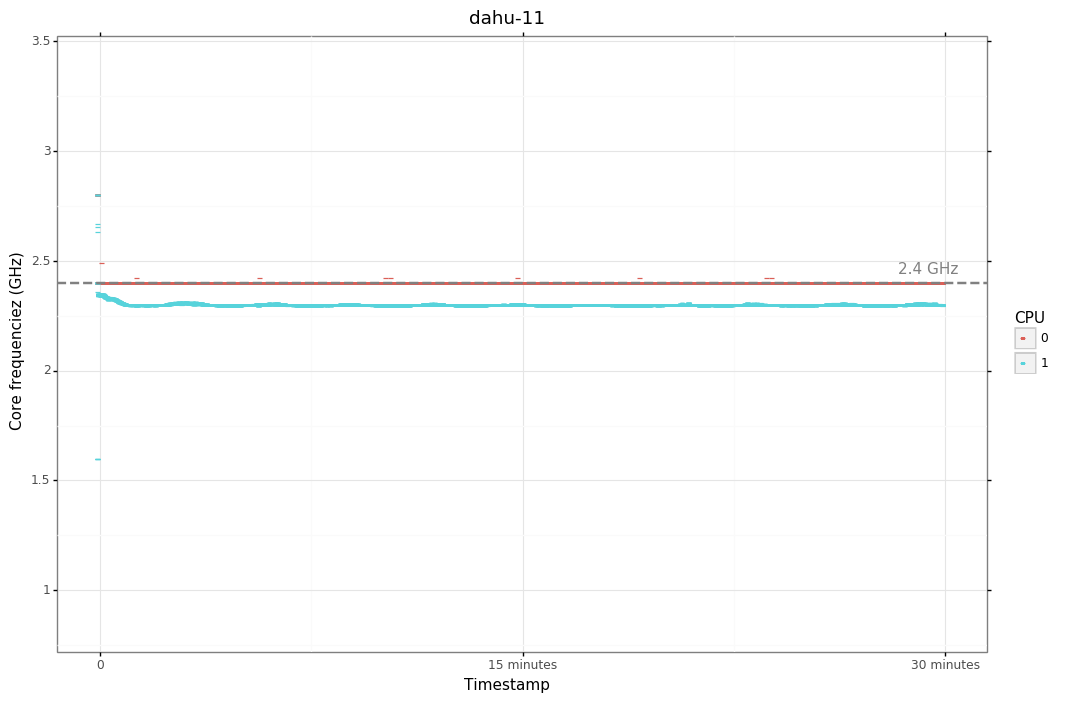

<ggplot: (-9223363243453427277)>


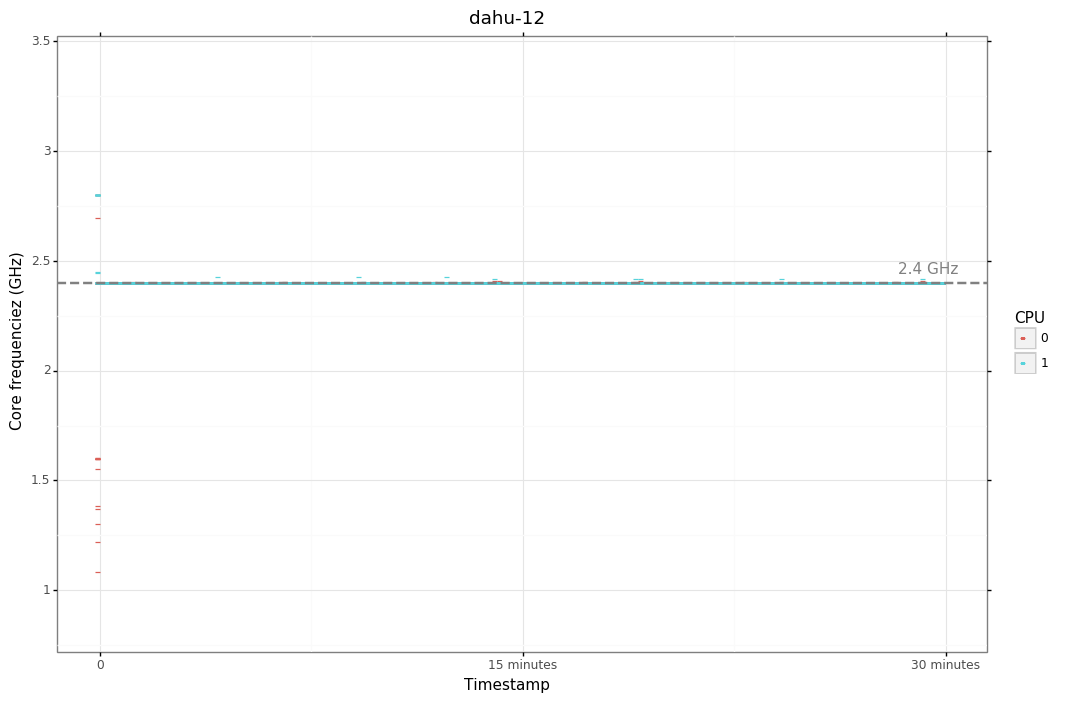

<ggplot: (-9223363243438707533)>


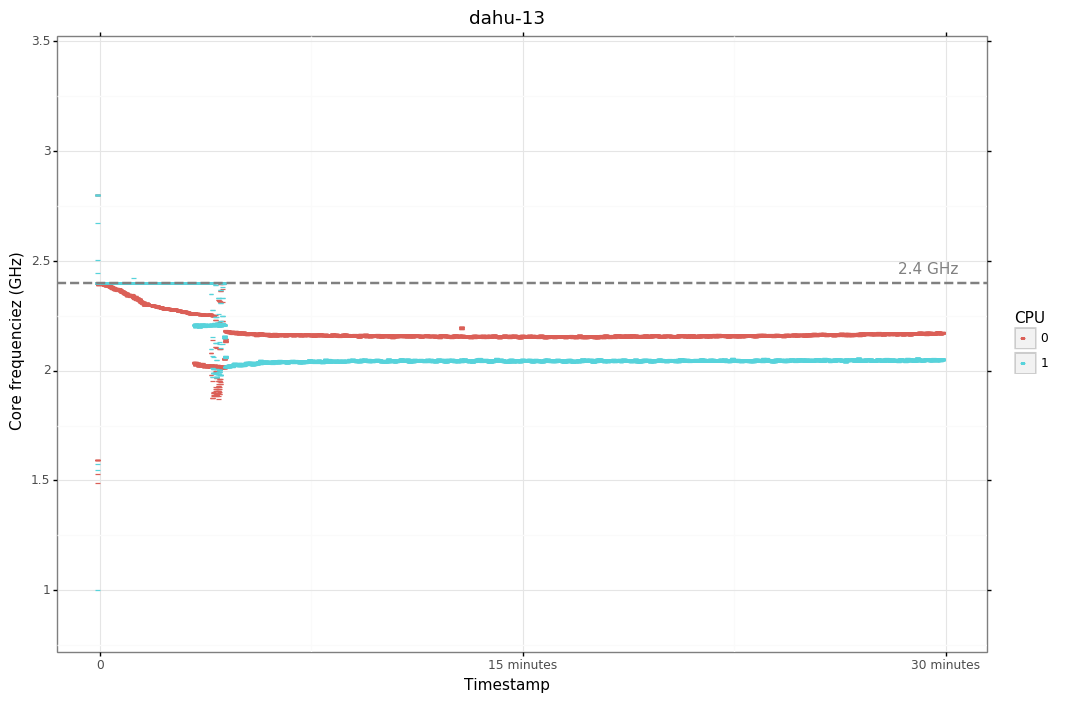

<ggplot: (8793415382841)>


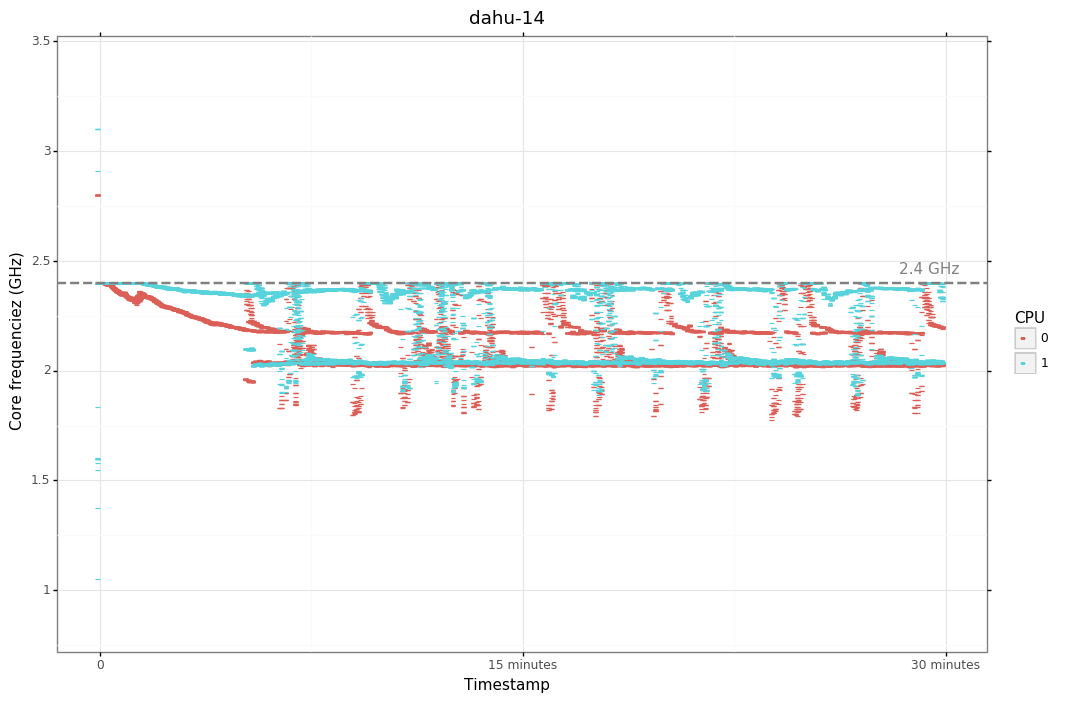

<ggplot: (8793416044471)>


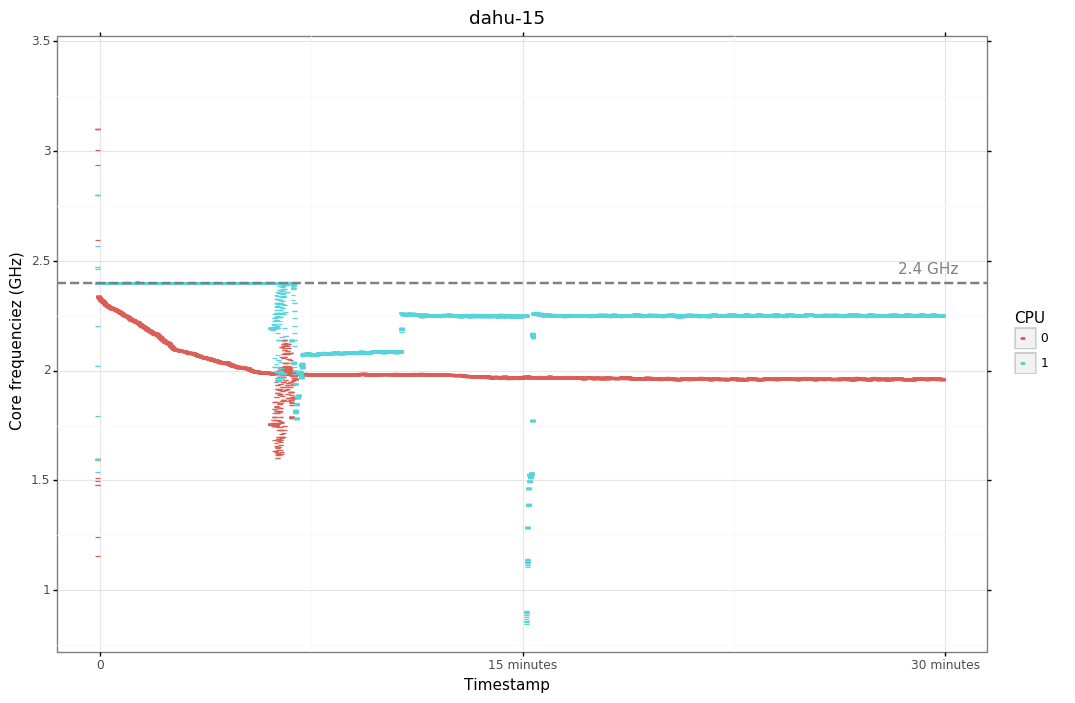

<ggplot: (-9223363243440112324)>


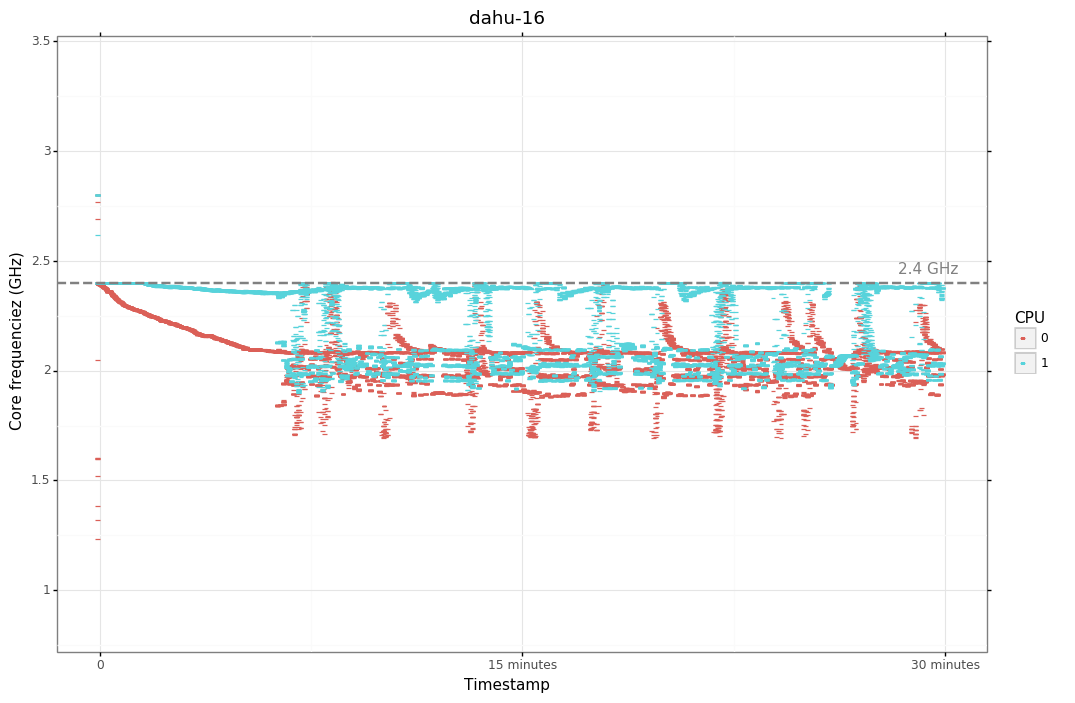

<ggplot: (-9223363243438028586)>


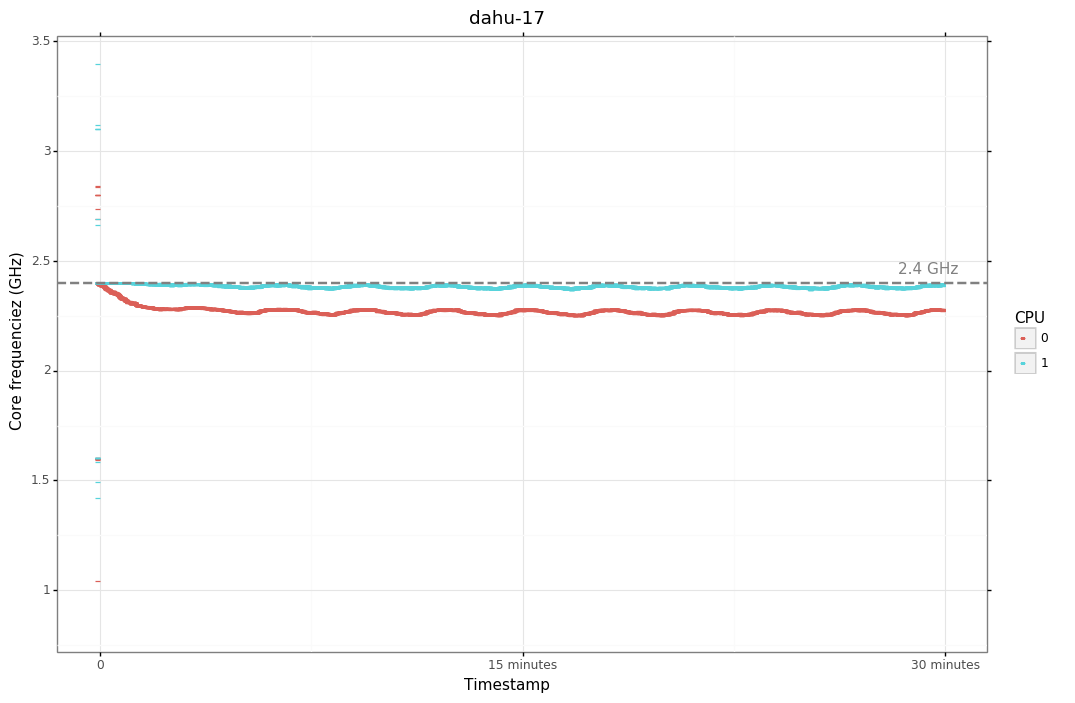

<ggplot: (-9223363243438892642)>


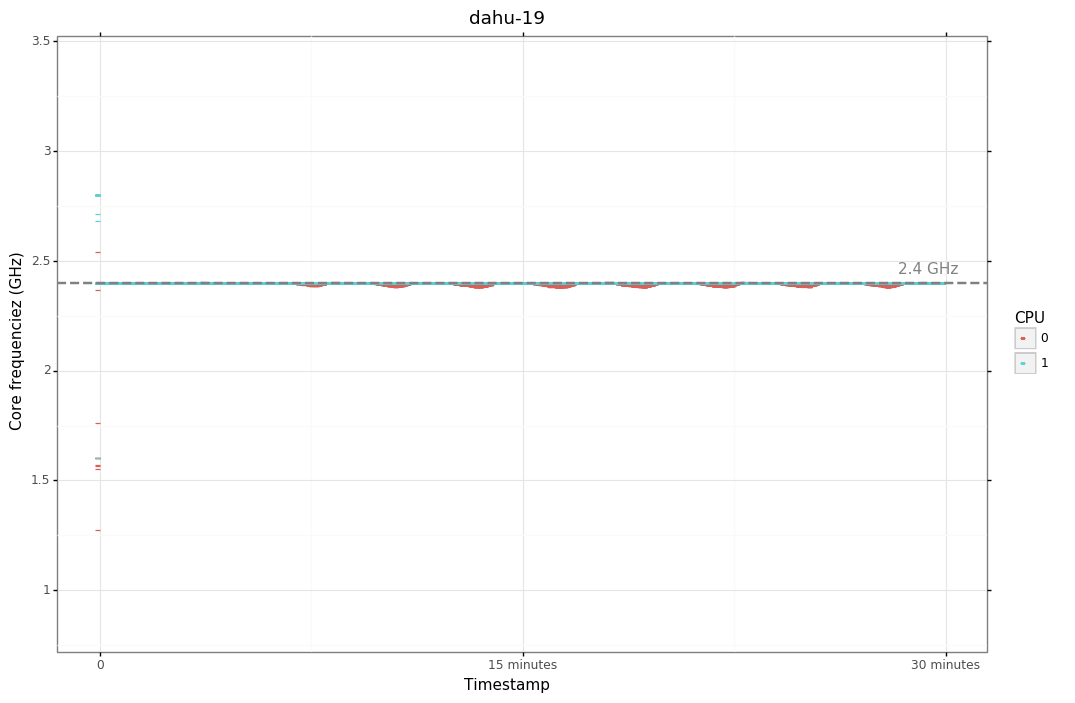

<ggplot: (8793415867200)>


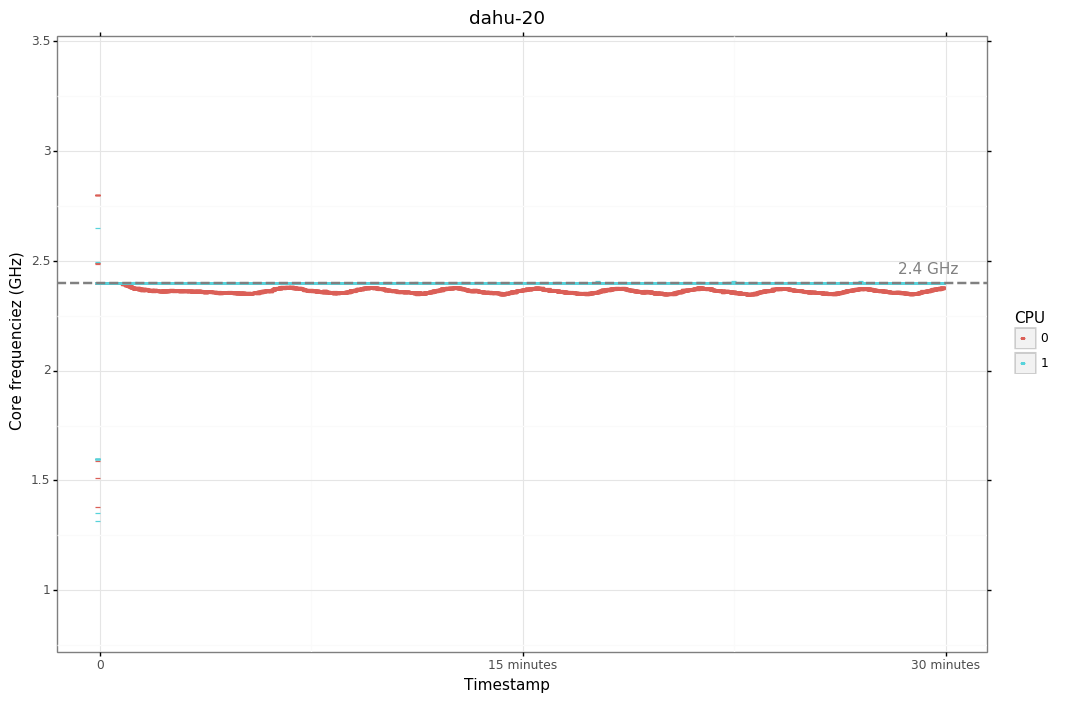

<ggplot: (-9223363243438924533)>


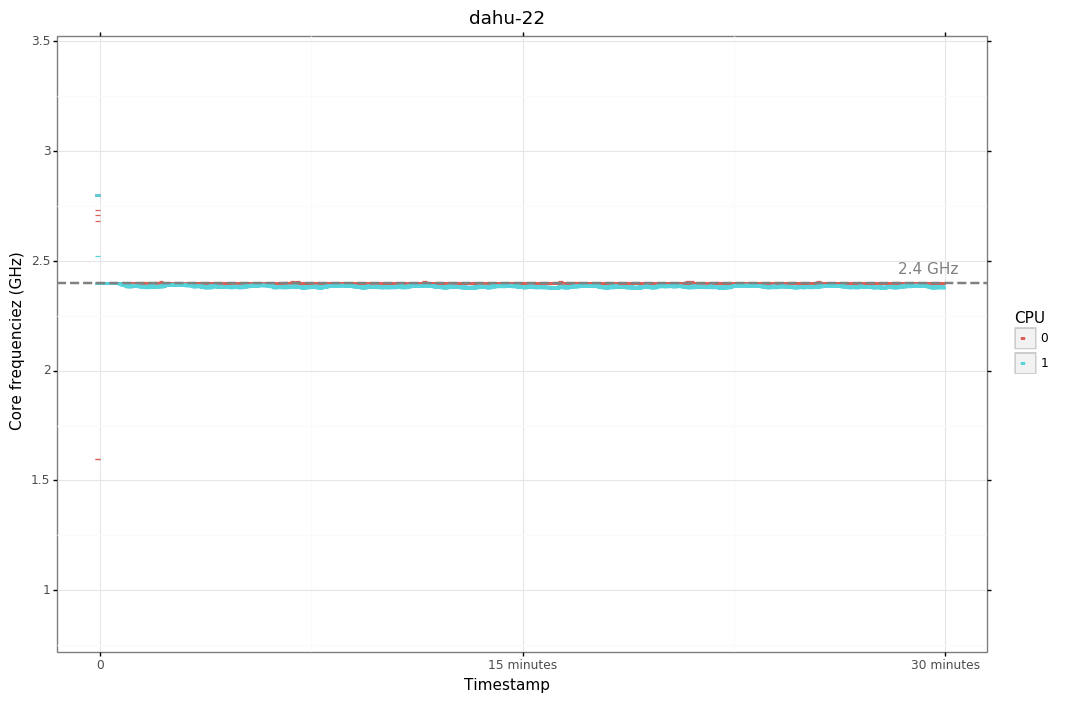

<ggplot: (-9223363243439105441)>


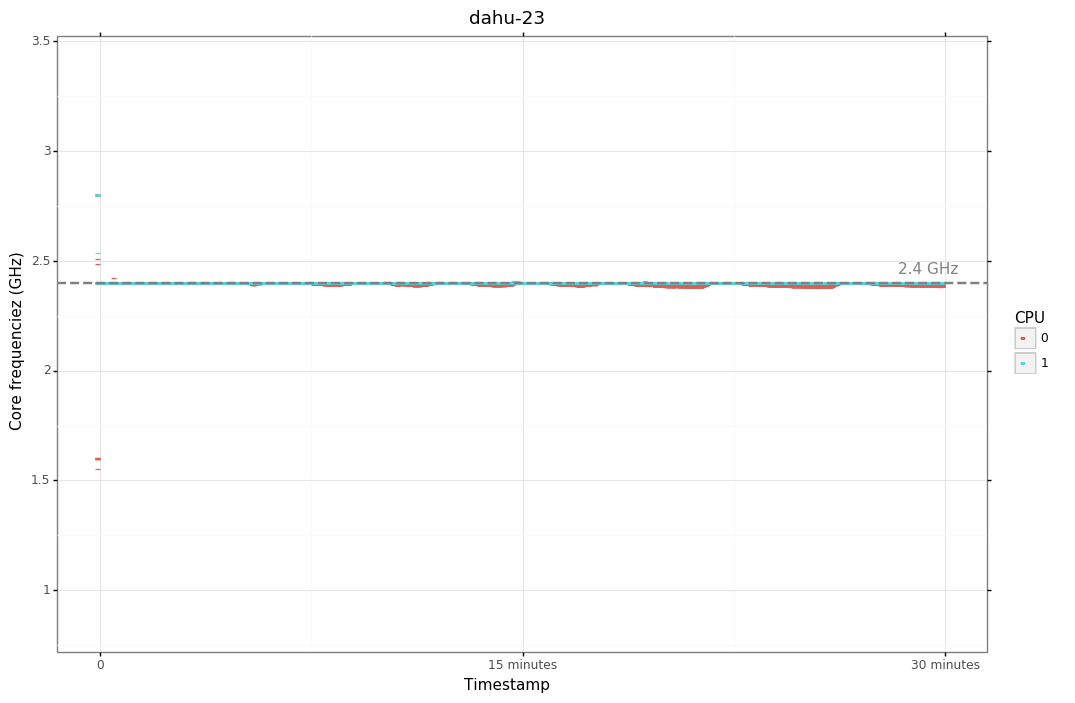

<ggplot: (8793417871224)>


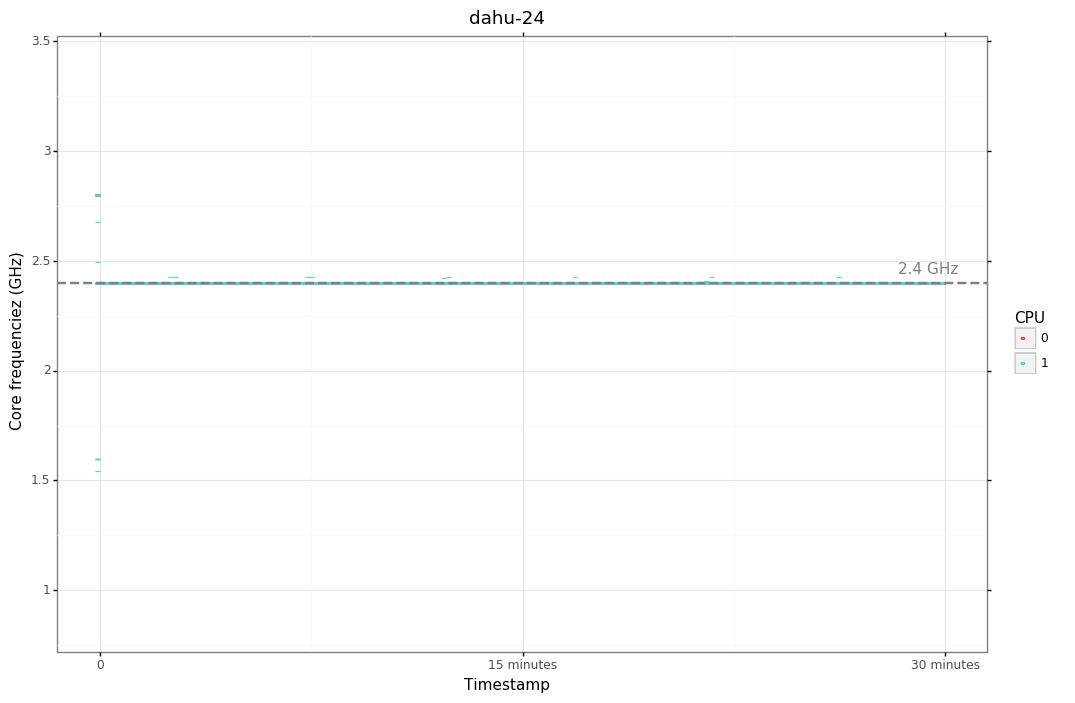

<ggplot: (-9223363243437383010)>


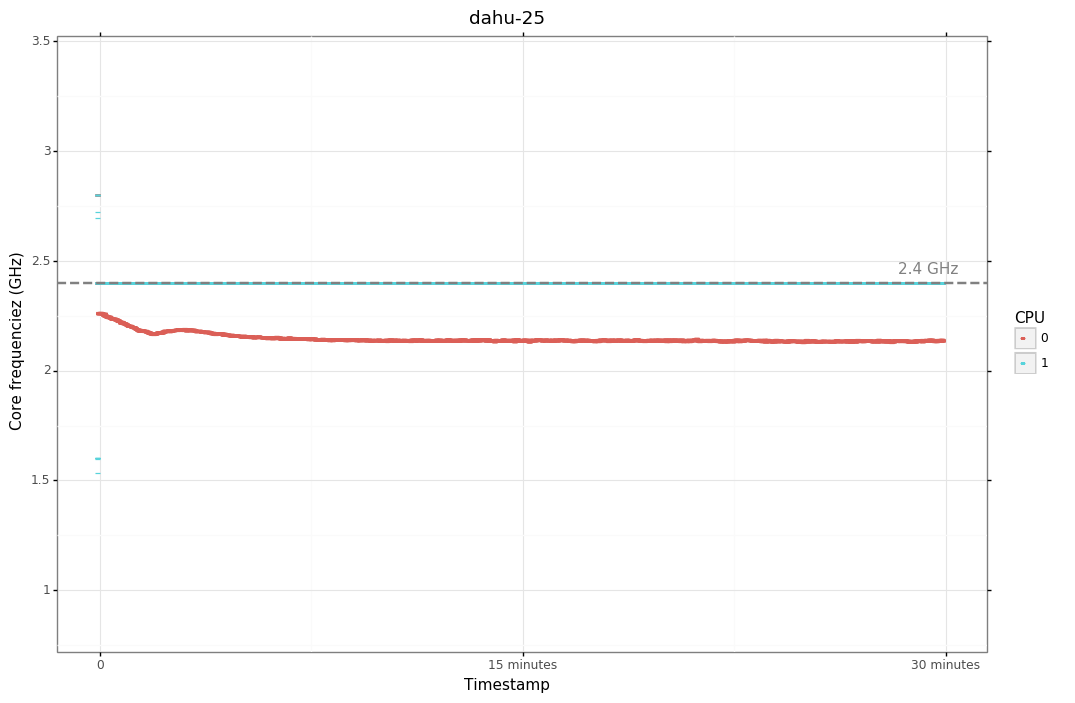

<ggplot: (-9223363243437295125)>


In [9]:
freq['cpu'] = freq['core_id'] % 2

generic_plot(freq, y='frequency', y_label='Core frequenciez (GHz)', draw_line=False, hline=(2.4, ' GHz'))

### Performance

In [10]:
median_perf = int(round(perf['gflops'].median()))
median_perf

30

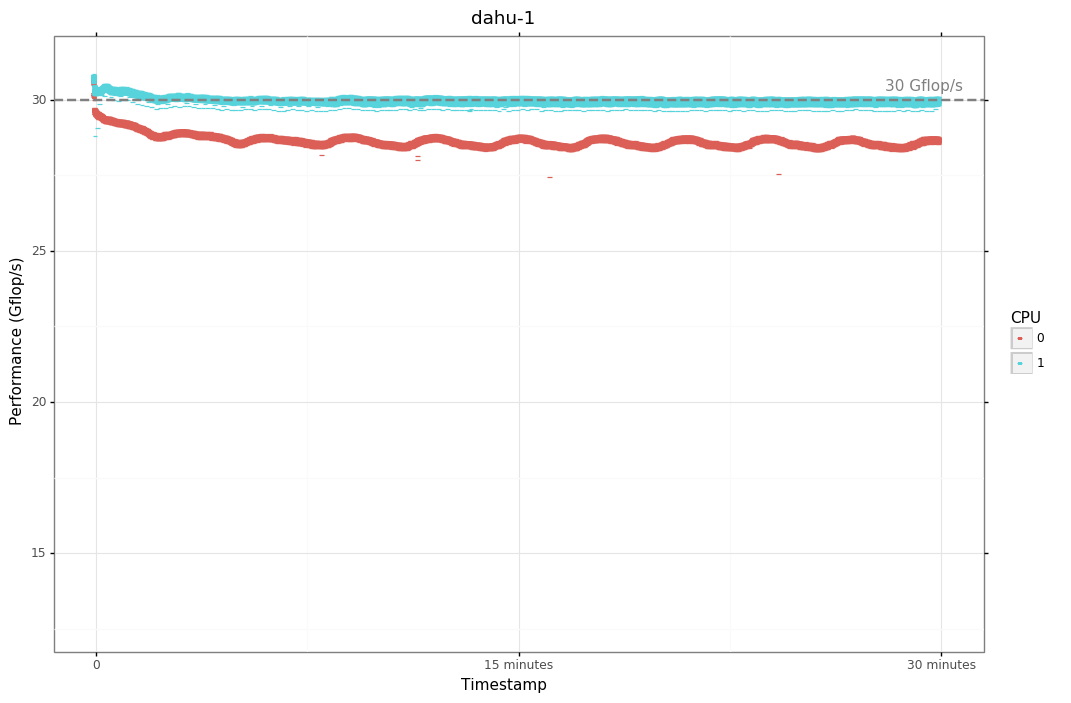

<ggplot: (-9223363243438660506)>


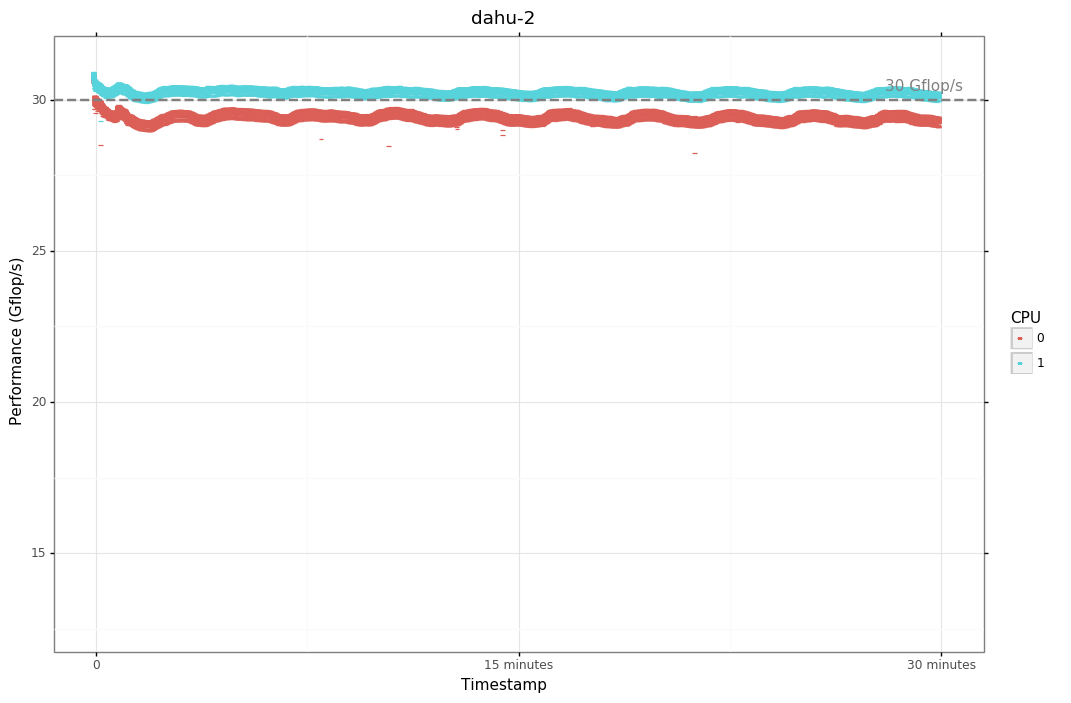

<ggplot: (8793414661268)>


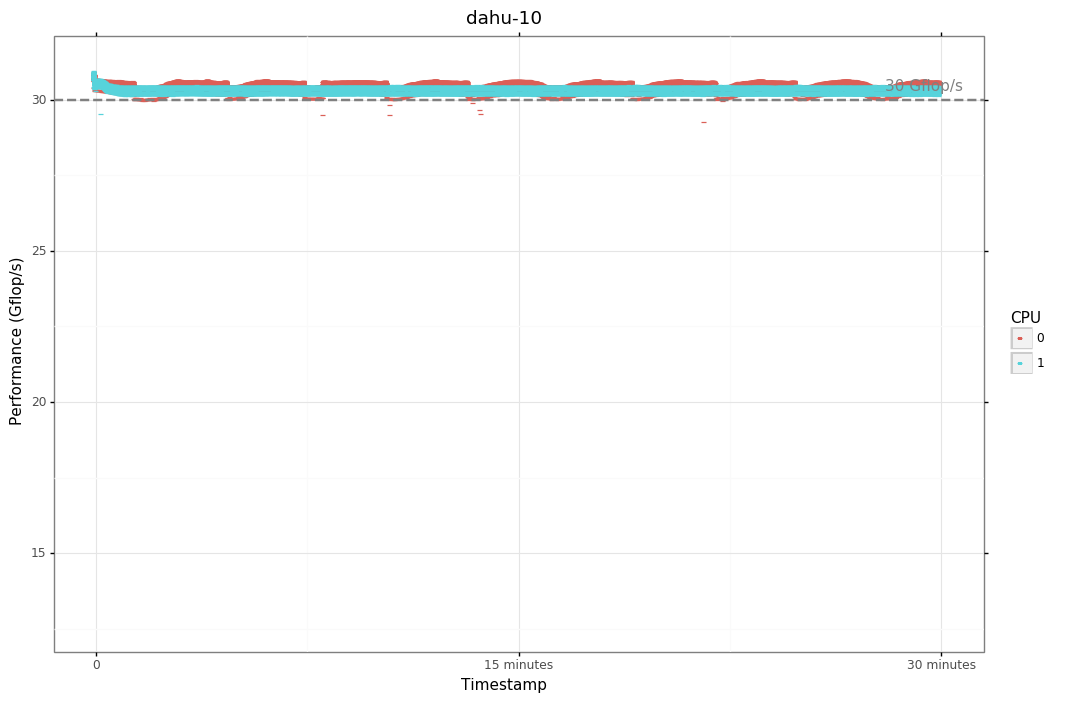

<ggplot: (8793417480491)>


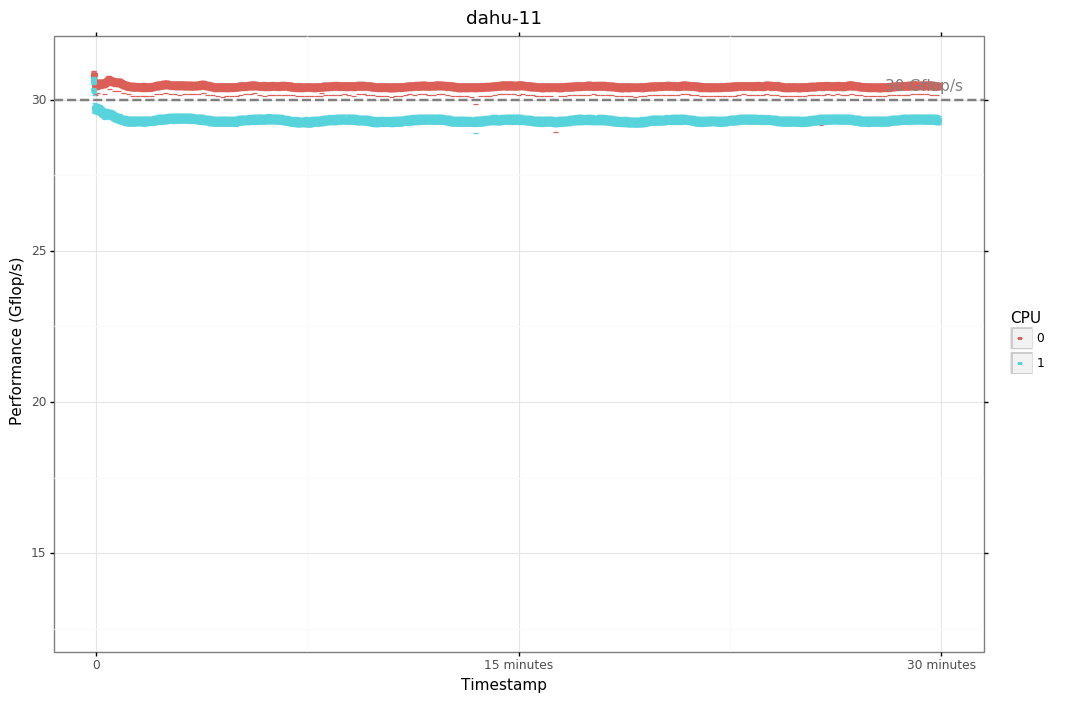

<ggplot: (-9223363243438711015)>


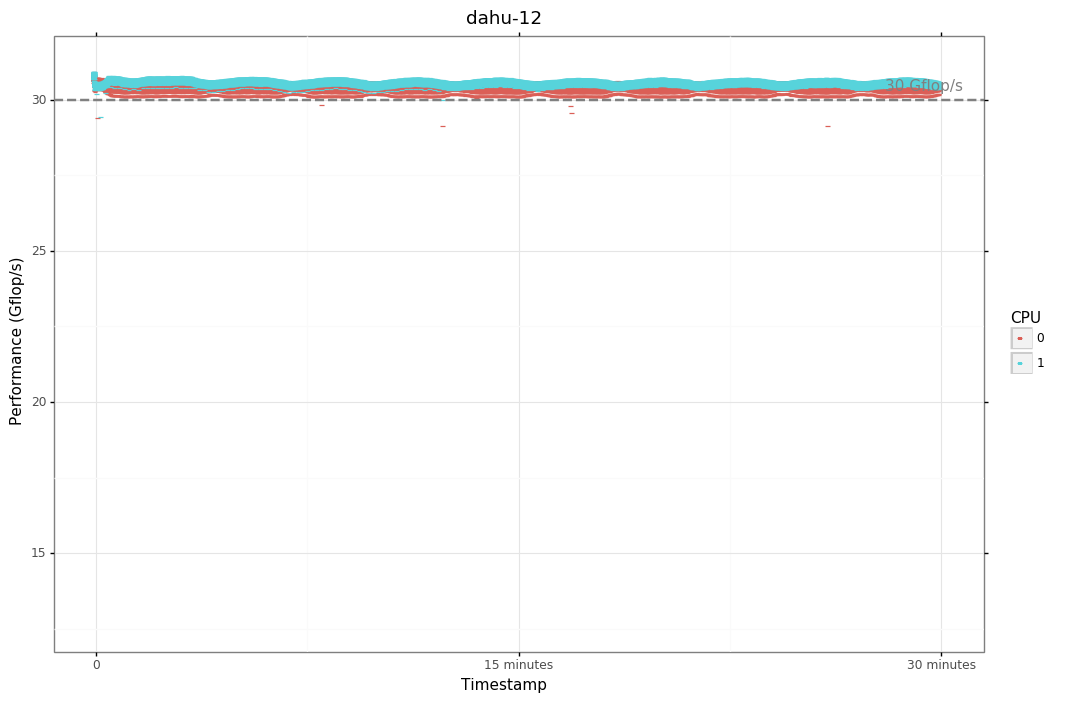

<ggplot: (-9223363243437223322)>


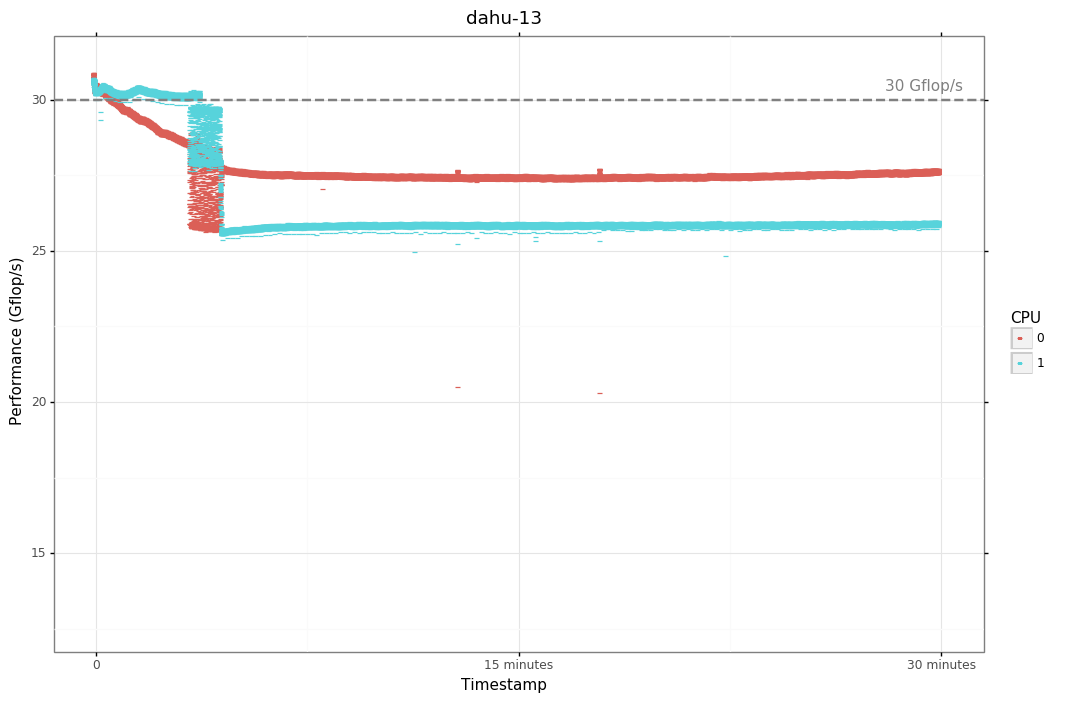

<ggplot: (-9223363243453645487)>


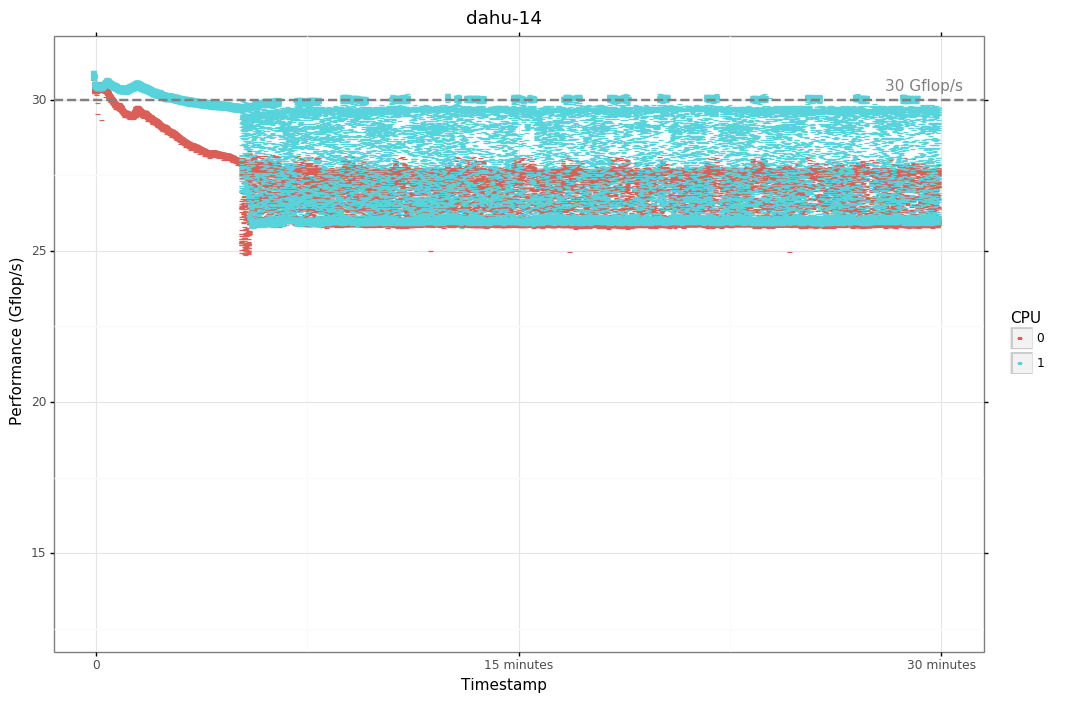

<ggplot: (8793416204222)>


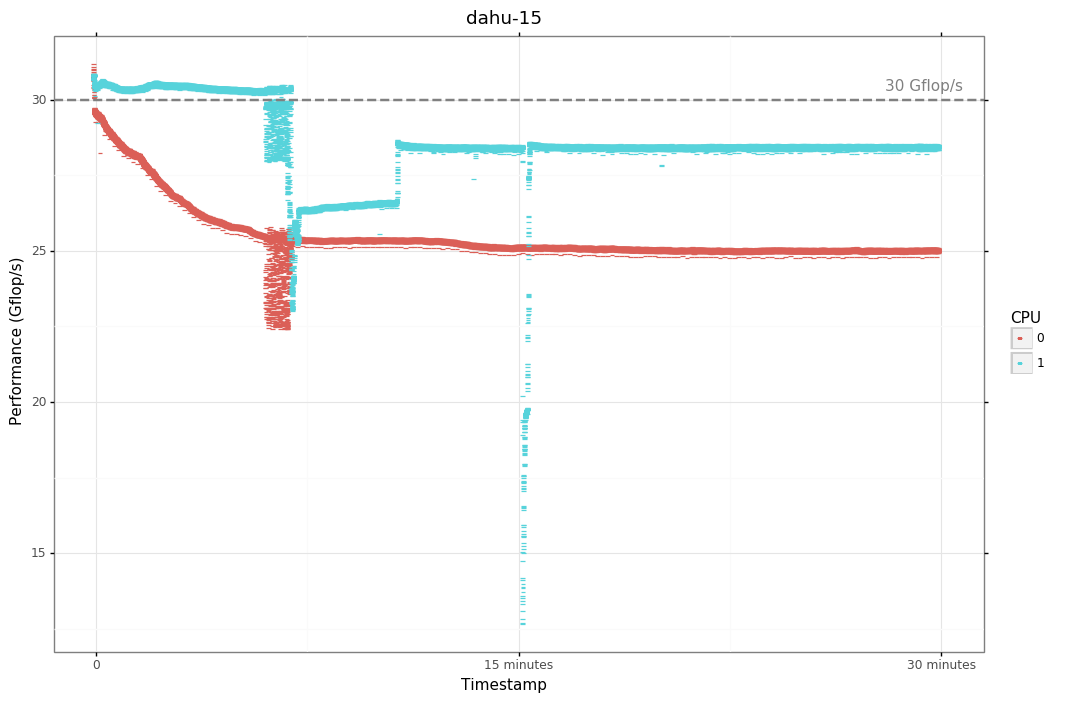

<ggplot: (-9223363243439216331)>


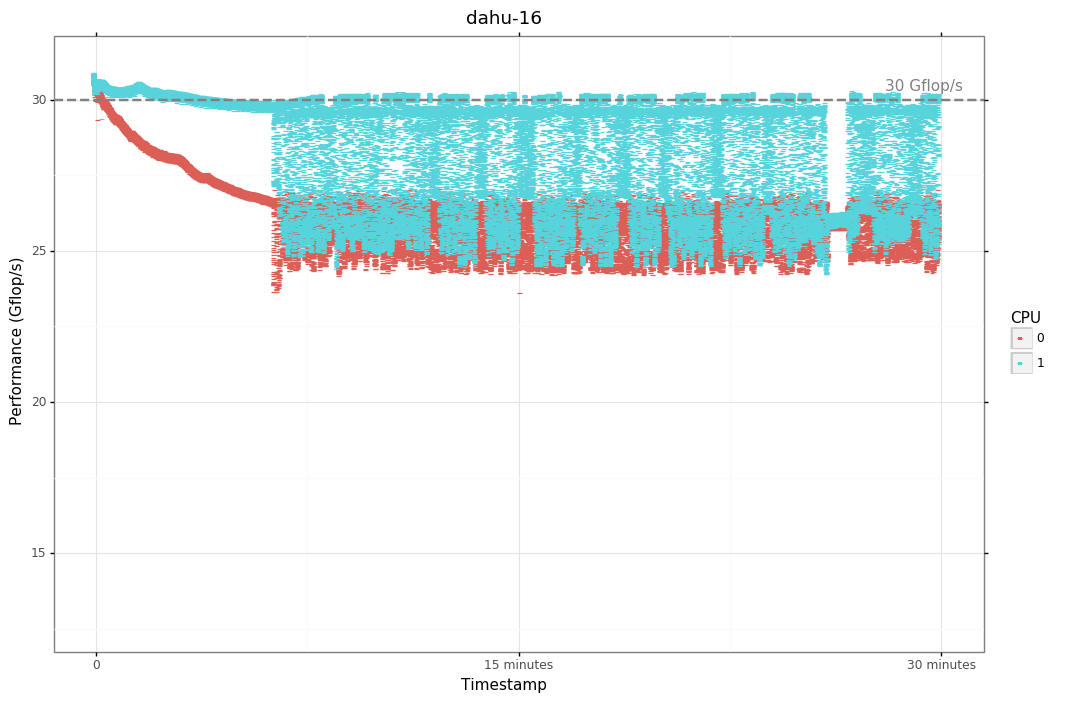

<ggplot: (-9223363243438925915)>


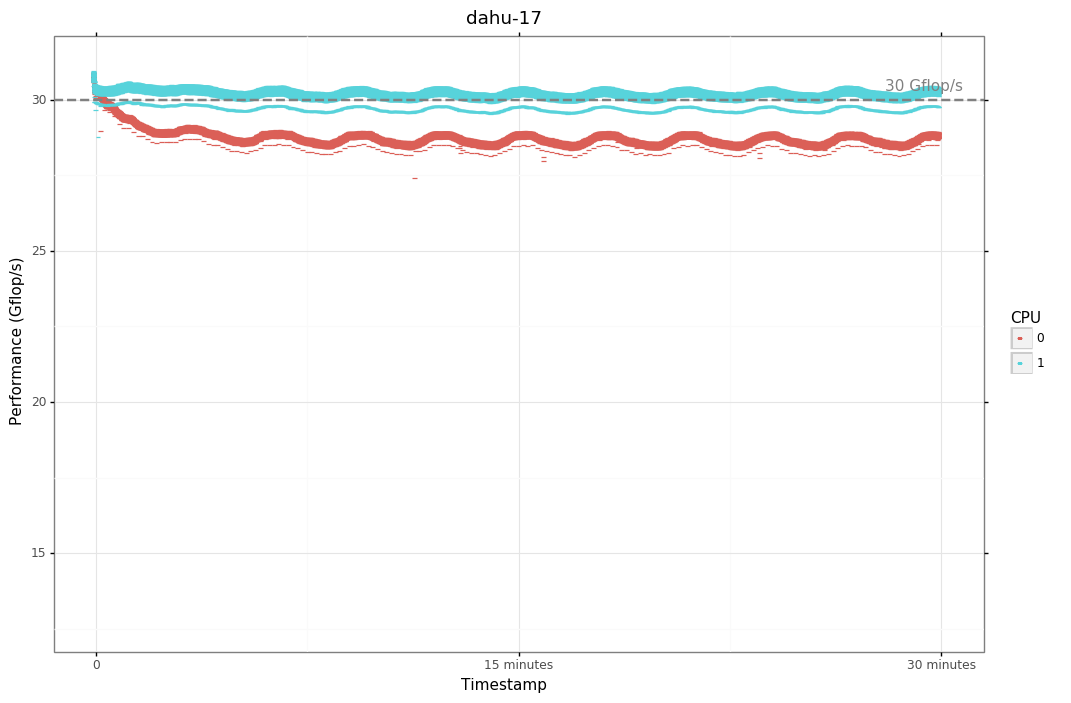

<ggplot: (-9223363243447409860)>


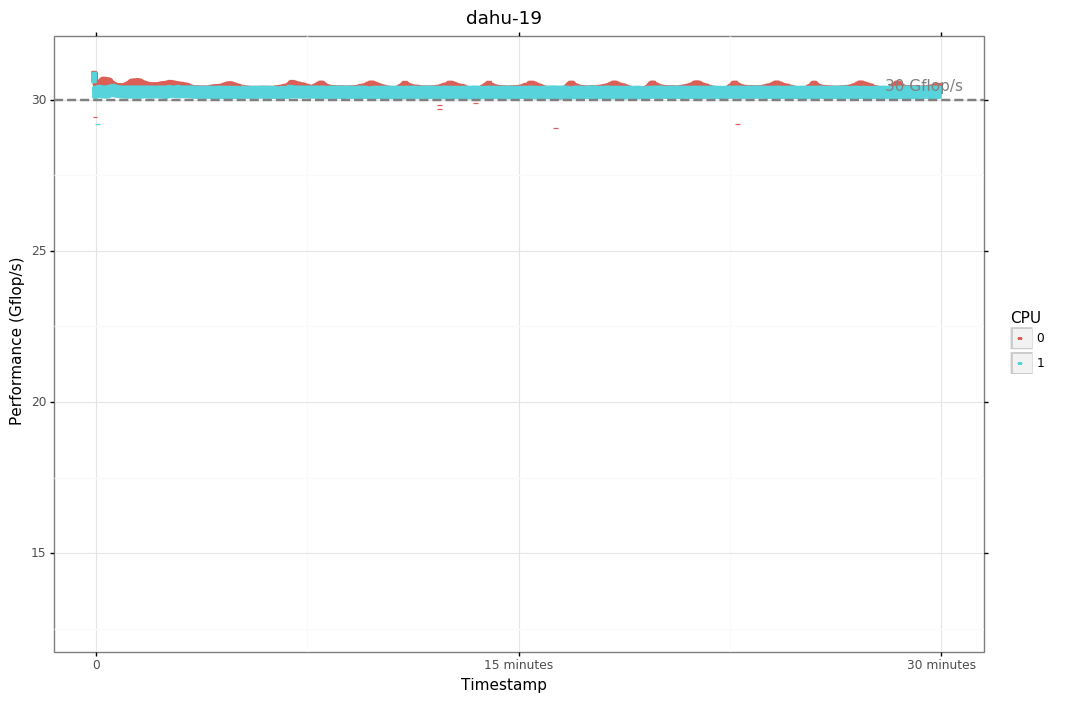

<ggplot: (-9223363243438925915)>


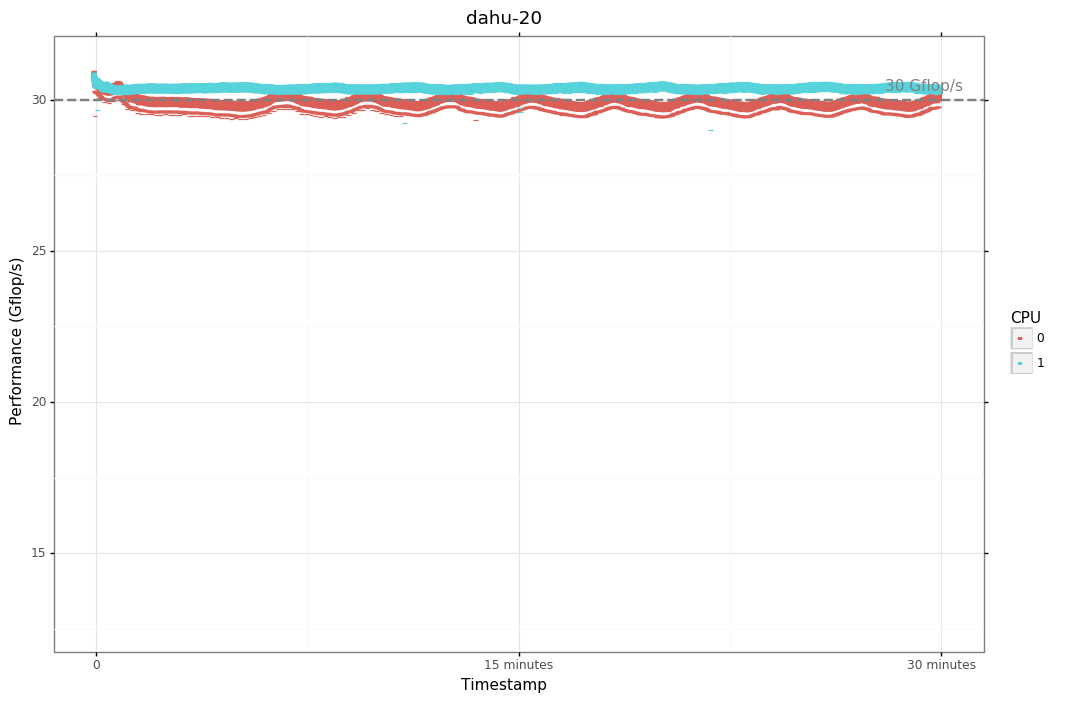

<ggplot: (-9223363243447409902)>


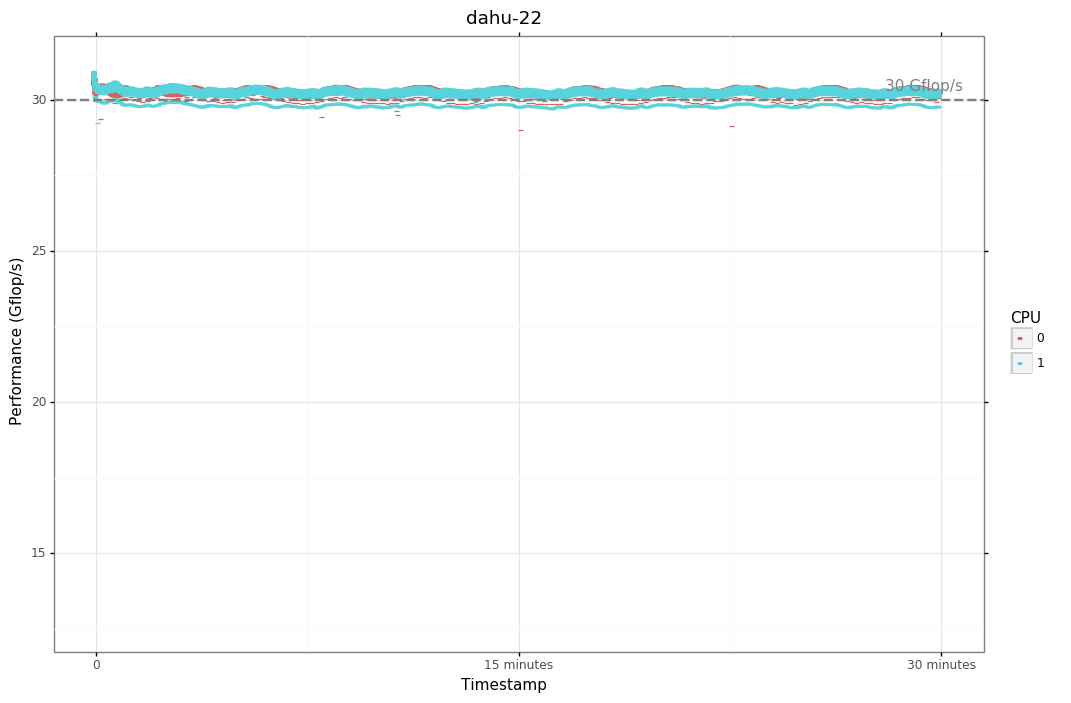

<ggplot: (8793417521307)>


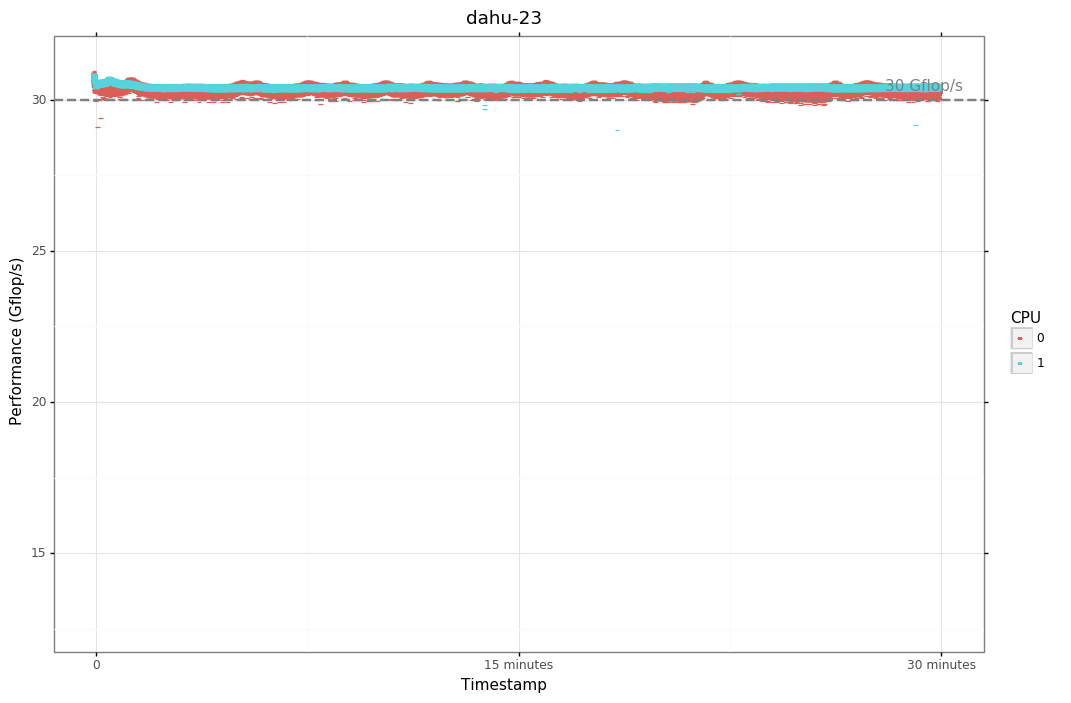

<ggplot: (-9223363243487342497)>


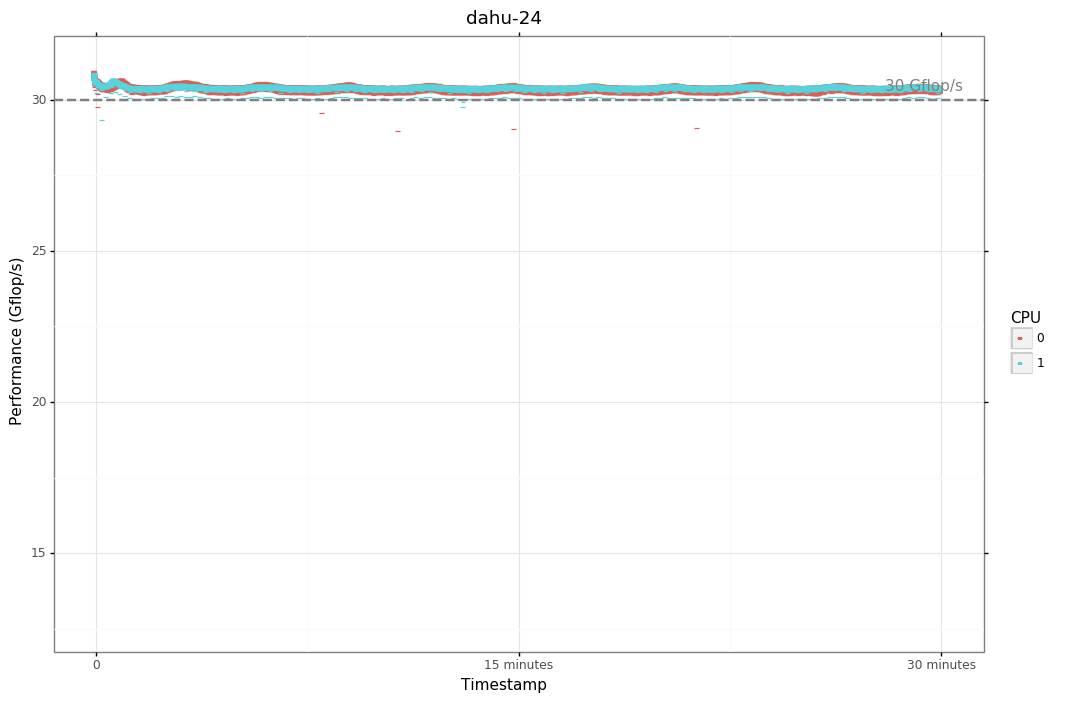

<ggplot: (8793414673142)>


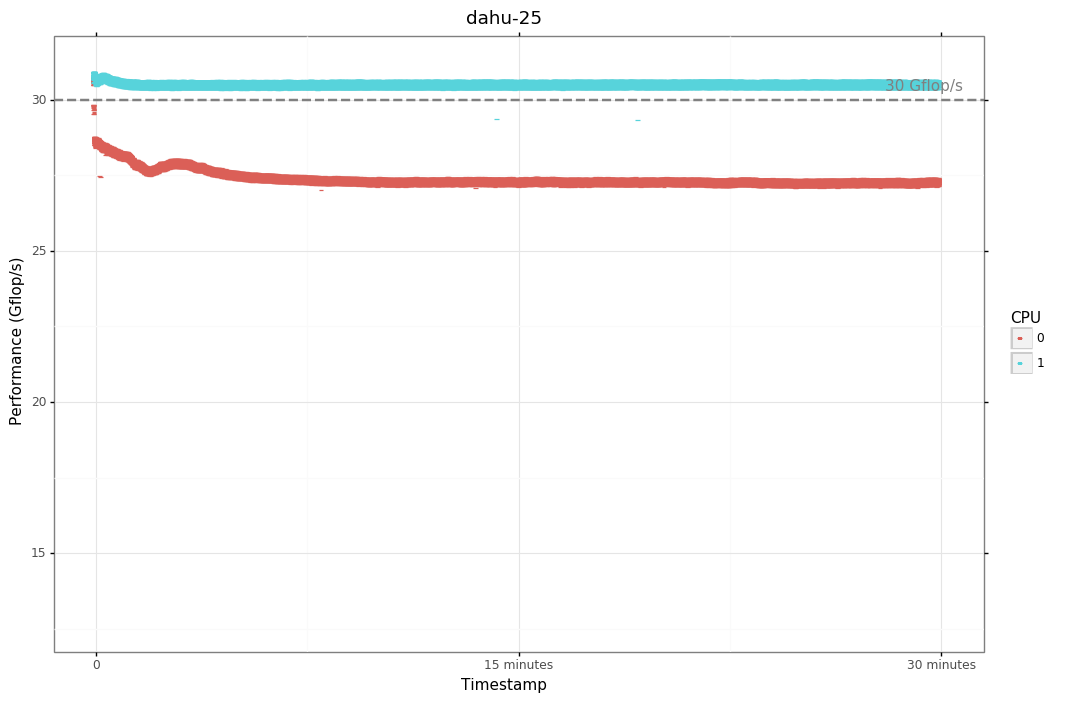

<ggplot: (8793415917523)>


In [11]:
perf['cpu'] = perf['core_id'] % 2

generic_plot(perf, y='gflops', y_label='Performance (Gflop/s)', draw_line=False, hline=(median_perf, ' Gflop/s'))